In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


## Index
- [Importing The Libraries](#importing-the-libraries)
- [Load The Dataset](#load-the-dataset)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    * [Structure of Data](#structure-of-data)
    * [Distribution of Crime Category](#distribution-of-crime-category)
    * [Frequency of Different Crime Categories Across Various Areas](#area-wise-crime)
    * [Crime Frequency on the basis of Crime Classifications - Part 1 & 2](#crimes-by-parts)
    * [Exploration and Analysis with Dates](#dates-analysis)
     * [Feature Engineering](#feature-engineering)
    * [Exploration and Analysis With Time When Crime Occurred](#time-analysis)
    * [Exploratrion with Victim Age, Sex, and Descent](#victim-age-sex-descent)
    * [Visualizing Other Features](#other-analysis)
- [Data Preprocessing](#data-preprocess)
    * [Separating Features and Target Label](#separate-feature-and-target)
    * [Splitting the Dataset in Train-Test Split](#train-test-split)
    * [Preprocessing `Modus_Operandi` Feature](#preprocess-modus-operandi)
    * [Dropping Unnecessay Columns from Train Data](#drop-columns)
    * [Defining Custom Transformers for `Premise_Code` and `Victim_Descent`](#custom-transformers)
    * [Defining Pipeline and ColumnTransformer](#pipeline-and-column-transformer)
    * [Transforming the Validation Data](#val-data-transform)
- [Logistic Regression (Model 1)](#logit)
    * [Insight with Base Logistic Regression Model](#base-logit-insights)
    * [Insights on Cross-Validation on Base Logit Model](#insight-base-logit-cv)
    * [Insights Of Hyper-Parameter Tuning on Logistic Regression Model](#insight-tuning-logit)
    * [Insights of Logistic Regression Model With RFE Feature Selection](#insight-rfe-logit)
    * [Logistics Regression Model Final Interpretations](#logit-final)
- [Decision Tree Classifier (Model 2)](#dtree)
    * [Insights on Base Decision Tree Classifier Along With Cross Validation](#insight-base-dtree-cv)
    * [Insights of Hyper-Parameter Tuning on Decision Tree Classifier](#insights-tuning-dtree)
    * [Insights of Decision Tree Classifier With RFE Feature Selection](#insight-rfe-dtree)
    * [Decision Tree Classifier Final Interpretations](#dtree-final)
- [Random Forest Classifier (Model 3)](#rforest)
    * [Insights on Base Random Forest Classifier Along With Cross Validation](#base-rforest)
    * [Insights After Hyper Parameter Tuning On Random Forest Classifier](#rforest-tuning)
    * [Insights On Random Forest Classifier After RFE Feature Selection](#insights-rfe-rforest)
    * [Random Forest Classifier Final Interpretations](#rforest-final)
- [Support Vector Classifier (Model 4)](#svc)
    * [Insights on Base SVC Along With Cross Validation](#base-svc)
    * [Insights After Hyper Parameter Tuning On SVC](#svc-tuning)
    * [SVC Final Interpretations](#svc-final)
- [LightGBM Classifier (Model 5)](#lgbm)
    * [Insights After Hyper-parameter Tuning of LGBMClassifier](#lgbm-tuning)
    * [Insights After RFE Feature Selection LightGBM Model](#lgbm-rfe)
- [Final Model Comparison And Submission](#final-model-comp)

<a id="importing-the-libraries"></a>
# Importing The Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, RobustScaler
                        
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFE

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

<a id="load-the-dataset"></a>
# Load The Dataset

In [3]:
data = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
testData = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

<a id="exploratory-data-analysis"></a>
# Exploratory Data Analysis

<a id="structure-of-data"></a>
### Structure of Dataset

In [4]:
data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
data.shape

(20000, 22)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

#### Insights
- There are 20000 rows and 21 feeatures in our dataset. The features are either of object or float type.
- The dates are present as Object type. I must convert them to datetime object to extract meaningful information.
- The target variable is `Crime_Category`, which is categorical.

In [7]:
data.isna().sum() / len(data) * 100

Location                  0.000
Cross_Street             82.760
Latitude                  0.000
Longitude                 0.000
Date_Reported             0.000
Date_Occurred             0.000
Time_Occurred             0.000
Area_ID                   0.000
Area_Name                 0.000
Reporting_District_no     0.000
Part 1-2                  0.000
Modus_Operandi           13.705
Victim_Age                0.000
Victim_Sex               13.120
Victim_Descent           13.120
Premise_Code              0.000
Premise_Description       0.025
Weapon_Used_Code         63.325
Weapon_Description       63.325
Status                    0.000
Status_Description        0.000
Crime_Category            0.000
dtype: float64

#### Insights
- There are missing values in our dataset.
- Features `Cross_Street`, `Weapon_Used_Code` and `Weapon_Description` have high number of missing values. 

<a id="distribution-of-crime-category"></a>
### Distribution of Crime Categories

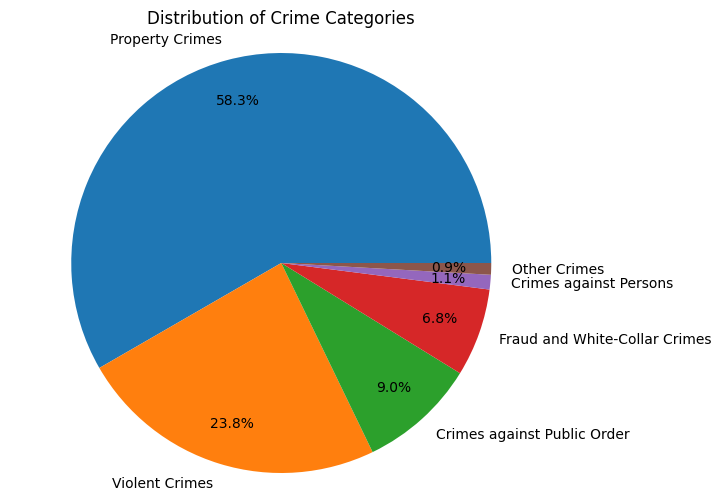

In [8]:
target_labels = data["Crime_Category"].value_counts().index
target_values = data["Crime_Category"].value_counts().values / len(data) * 100

plt.figure(figsize=(7,6))
plt.pie(target_values, labels=target_labels, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.1)
plt.title('Distribution of Crime Categories')
plt.axis("equal")
plt.show()

#### Insights
- The "Property Crimes" accounts for more than half of the dataset, i.e 58%. And rest of the categories account for remaining 42%. This implies that our dataset is quite imbalanced.

In [9]:
data["Location"].value_counts() / len(data) * 100

Location
6TH                                        0.165
7TH                                        0.160
VERMONT                      AV            0.155
6TH                          ST            0.155
7TH                          ST            0.150
                                           ...  
2700 E  1ST                          ST    0.005
9300    SWINTON                      AV    0.005
MCKINLEY                                   0.005
WADE                         ST            0.005
DALTON                       AV            0.005
Name: count, Length: 12399, dtype: float64

#### Insight
- In `Location` feature, there are 12400 unique values. The most frequent value is contributing only 0.16% of the dataset.

In [10]:
data[["Longitude", "Latitude"]].value_counts()

Longitude  Latitude
 0.0000    0.0000      78
-118.6274  34.1883     26
-118.5583  34.2440     23
-118.4200  34.0600     19
-118.3225  34.1030     18
                       ..
-118.3805  33.9574      1
           33.9586      1
           33.9599      1
           34.0959      1
-118.3279  33.9837      1
Name: count, Length: 13278, dtype: int64

#### Insights
- The `Latitude` and `Longitude` has some irrelevant 0 values. These values either represent missing values, or errors, or unknowns.

In [11]:
data[["Area_ID", 'Area_Name']].value_counts()

Area_ID  Area_Name  
12.0     77th Street    1345
14.0     Pacific        1157
1.0      Central        1156
3.0      Southwest      1130
18.0     Southeast      1067
15.0     N Hollywood    1065
6.0      Hollywood      1014
13.0     Newton          999
20.0     Olympic         960
7.0      Wilshire        943
2.0      Rampart         931
8.0      West LA         910
9.0      Van Nuys        902
5.0      Harbor          872
19.0     Mission         870
11.0     Northeast       839
21.0     Topanga         792
10.0     West Valley     790
17.0     Devonshire      769
4.0      Hollenbeck      755
16.0     Foothill        734
Name: count, dtype: int64

#### Insights
- 77th Street reported most number of crimes, followed by Pacific, Central, Southwest, Southeast, and Hollywood.
- Foothill reported the least number of crimes.

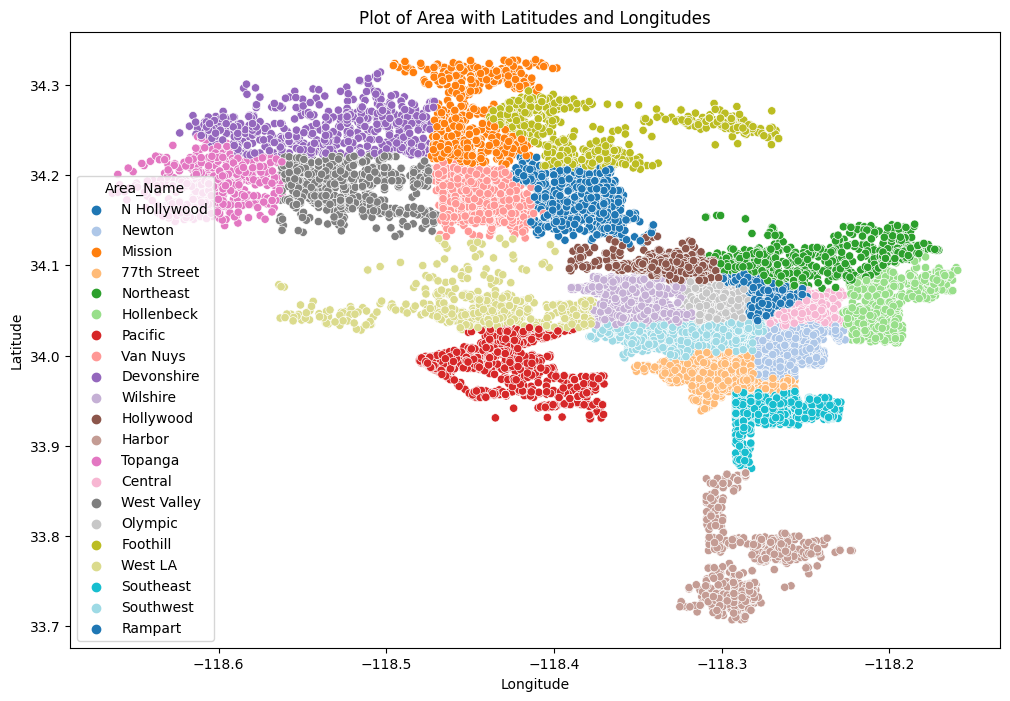

In [12]:
filtered_data = data[(data['Longitude'] != 0) & (data['Latitude'] != 0)]

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Area_Name', data=filtered_data, palette='tab20', ax=ax)
plt.title("Plot of Area with Latitudes and Longitudes")
plt.show()

#### Insights
- The plot of Latitudes and Longitudes are clearly making clusters of different Areas. 

<a id="area-wise-crime"></a>
### Frequency of Different Crime Categories Across Various Areas

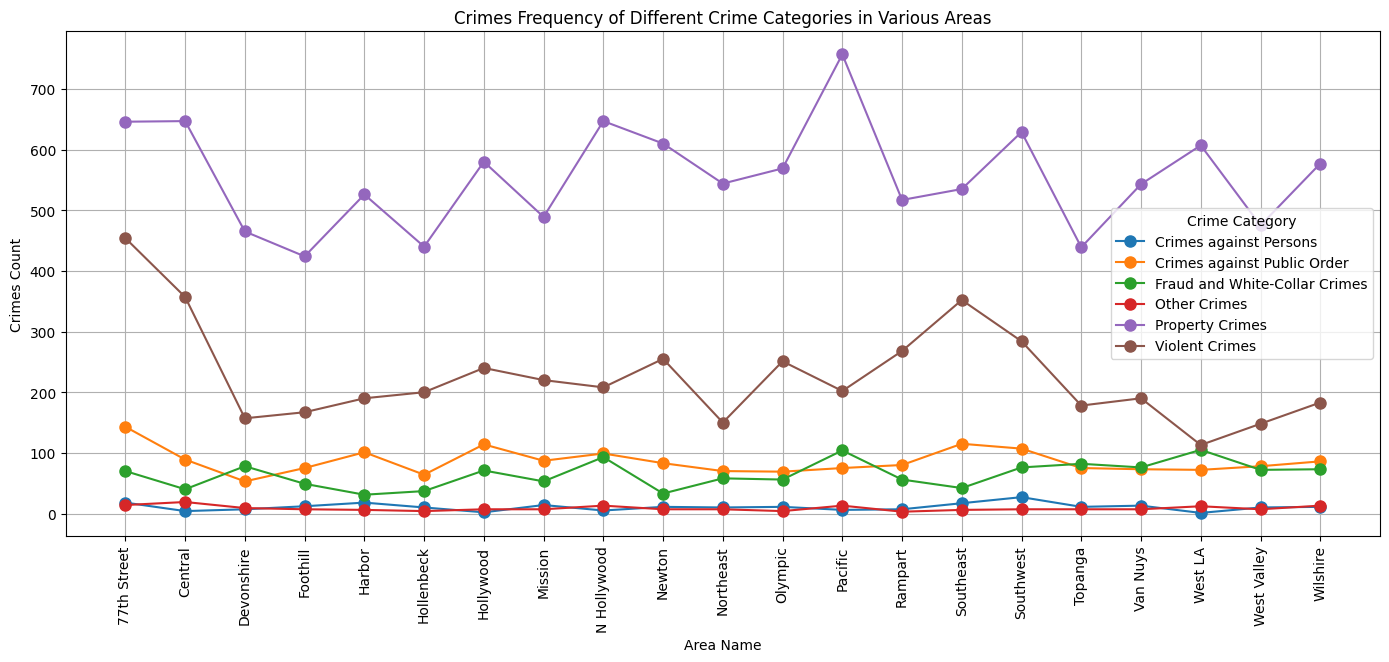

In [13]:
area_wise_crime = pd.crosstab(index=data["Area_Name"], columns=data["Crime_Category"])

fig, ax = plt.subplots(figsize=(14, 6))
area_wise_crime.plot(kind='line', marker='o', markersize=8, ax=ax)
plt.xlabel('Area Name')
plt.ylabel('Crimes Count')
plt.title('Crimes Frequency of Different Crime Categories in Various Areas')
plt.legend(title='Crime Category')
plt.tight_layout()
plt.grid(True)
plt.xticks(range(len(area_wise_crime.index)), area_wise_crime.index, rotation='vertical')
plt.show()

#### Insights
- The Pacific area recorded the highest number of property and white-collar crimes.
- The 77th Street area reported the highest number of violent crimes and crimes against public order.
- West LA had the lowest incidence of violent crime but a notable number of property crimes.

Let's look the crime frequency in the areas on the basis of crime classifications, i.e Part 1 and Part 2.
- Part I Offenses include murder, rape, aggravated assault, robbery, burglary, larceny, motor vehicle theft, arson, and human trafficking.
 - Murder, rape, aggravated assault, human trafficking, and robbery are also known as Violent Crimes. 
 - Burglary, larceny, motor vehicle theft and arson are considered Property crimes.
- Part II crimes includes less serious crimes, such as Counterfeiting, Fraud, Vandalism, Gambling, etc


<br>Source: https://www.cityofroseville.com/DocumentCenter/View/26568/Description-of-Uniform-Crime-Offenses#:~:text=Part%20I%20Offenses%20are%20ten,%E2%80%9Cless%20serious%E2%80%9D%20crime%20classifications.

<a id="crimes-by-parts"></a>
### Crime Frequency on the basis of Crime Classifications - Part 1 & 2

In [14]:
data["Part 1-2"].value_counts()

Part 1-2
1.0    11637
2.0     8363
Name: count, dtype: int64

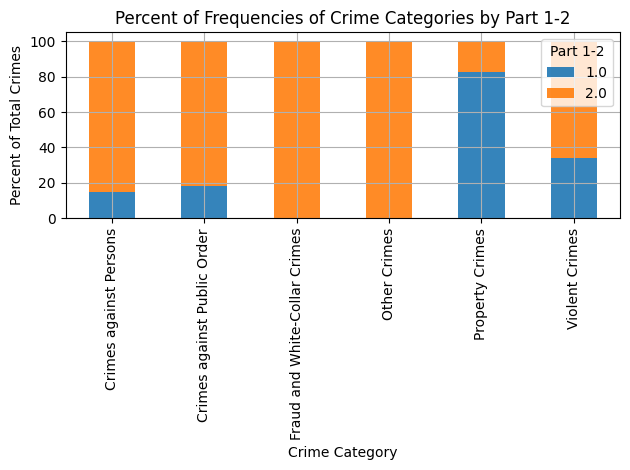

In [15]:
crimes_by_part = pd.crosstab(index=data["Crime_Category"], columns=data["Part 1-2"], normalize="index") * 100

crimes_by_part.plot(kind='bar', stacked=True, alpha=0.9)

plt.xlabel('Crime Category')
plt.ylabel('Percent of Total Crimes')
plt.title('Percent of Frequencies of Crime Categories by Part 1-2')
plt.legend(title='Part 1-2')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Insights 
- Most number of Part 1 crimes occurred under Property Crimes.
- Violent Crimes are 2nd most occurred crimes in our dataset, but more than 60% of thoses are Part 2, i.e less serious offences.
- Frauds, White Collar, and Other Crimes does not include Part 1 crime, as these are considered as Part 2 Crimes
- Crimes against Persons and Public Order also reported less than 20% as serious crimes.

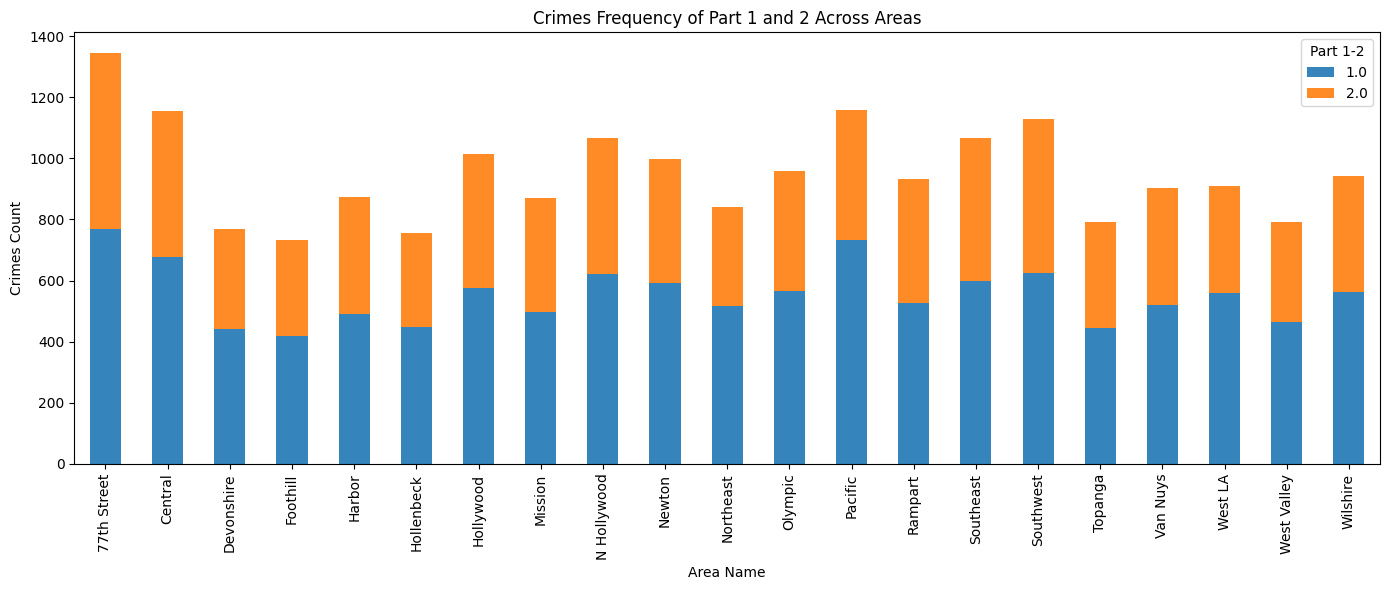

In [16]:
crime_parts_in_areas = pd.crosstab(index=data["Area_Name"], columns=data["Part 1-2"])

fig, ax = plt.subplots(figsize=(14, 6))
crime_parts_in_areas.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)
plt.xlabel('Area Name')
plt.ylabel('Crimes Count')
plt.title('Crimes Frequency of Part 1 and 2 Across Areas')
plt.legend(title='Part 1-2')
plt.tight_layout()
plt.xticks(range(len(area_wise_crime.index)), area_wise_crime.index, rotation='vertical')
plt.show()

#### Insights
- 77th Street reported most number of Part 1 and Part 2 crimes.
- Foothill reported least number of serious (Part 1) crimes.
- Whereas, Hollenbeck recorded least number of Part 2 offences.

<a id="dates-analysis"></a>
### Exploration and Analysis with Dates

In [17]:
data[["Date_Reported", "Date_Occurred"]]

,Date_Reported,Date_Occurred
0,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM
1,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM
2,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM
3,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM
4,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM
...,...,...
19995,05/24/2020 12:00:00 AM,05/24/2020 12:00:00 AM
19996,12/25/2020 12:00:00 AM,12/25/2020 12:00:00 AM
19997,09/25/2020 12:00:00 AM,09/25/2020 12:00:00 AM
19998,06/10/2020 12:00:00 AM,06/10/2020 12:00:00 AM


The Dates are not in right format. I have to first make them in correct format to get insights.

In [18]:
data["Date_Reported"] = pd.to_datetime(data["Date_Reported"], format='%m/%d/%Y %I:%M:%S %p')
data["Date_Occurred"] = pd.to_datetime(data["Date_Occurred"], format='%m/%d/%Y %I:%M:%S %p')

In [19]:
data[["Date_Reported", "Date_Occurred"]]

,Date_Reported,Date_Occurred
0,2020-03-09,2020-03-06
1,2020-02-27,2020-02-27
2,2020-08-21,2020-08-21
3,2020-11-08,2020-11-06
4,2020-02-25,2020-02-25
...,...,...
19995,2020-05-24,2020-05-24
19996,2020-12-25,2020-12-25
19997,2020-09-25,2020-09-25
19998,2020-06-10,2020-06-10


In [20]:
data["Date_Occurred"].dt.year.value_counts()

Date_Occurred
2020    20000
Name: count, dtype: int64

In [21]:
data["Date_Reported"].dt.year.value_counts()

Date_Reported
2020    19177
2021      532
2022      176
2023      108
2024        7
Name: count, dtype: int64

### Insights
- Crimes occurred in 2020 only. But, some crime incidents were reported in 2021, 2022, 2023, and 2024.

<a id="feature-engineering"></a>
#### Feature Engineering

In [22]:
data["Date_Occurred_Month"] = data["Date_Occurred"].dt.month

In [23]:
# Difference between the number of days from the occurrence and reporting of crime
data["Occurred_Reported_Diff"] = (data["Date_Reported"] - data["Date_Occurred"]).dt.days

In [24]:
data["Date_Occurred_Weekday"] = data["Date_Occurred"].dt.day_name()

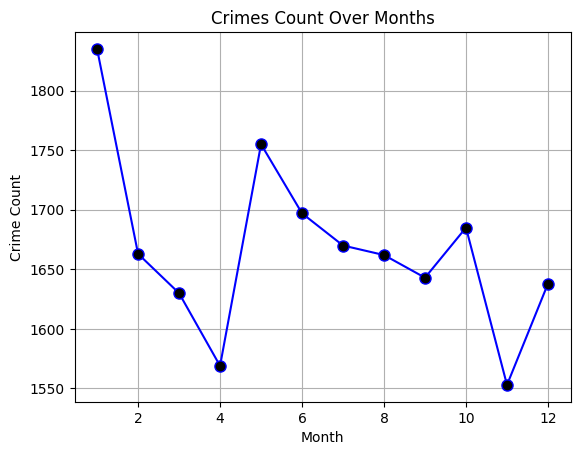

In [25]:
month_num = data["Date_Occurred_Month"].value_counts().sort_index().index
crime_count = data["Date_Occurred_Month"].value_counts().sort_index().values

plt.plot(month_num, crime_count, marker='o', markersize=8, markerfacecolor='black', linestyle='-', color='blue')
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.title("Crimes Count Over Months")
plt.grid(True)
plt.show()

#### Insights
- January reported the most number of crimes, and November reported the least.
- There is a consistent drop in crime reports from May to September.
- The most significant drops were seen post January, but got a spike increase in May.

In [26]:
crimes_by_categories_over_months = pd.crosstab(index=data['Date_Occurred_Month'], columns=data['Crime_Category'], margins=False)
crimes_by_categories_over_months

Crime_Category,Crimes against Persons,Crimes against Public Order,Fraud and White-Collar Crimes,Other Crimes,Property Crimes,Violent Crimes
Date_Occurred_Month,,,,,,
1,31,151,157,10,1047,439
2,32,151,121,18,959,382
3,15,134,107,23,985,366
4,10,138,107,13,948,353
5,15,157,110,26,1042,405
6,16,142,96,10,991,442
7,13,150,103,14,978,412
8,24,158,110,14,947,409
9,27,174,100,14,906,422


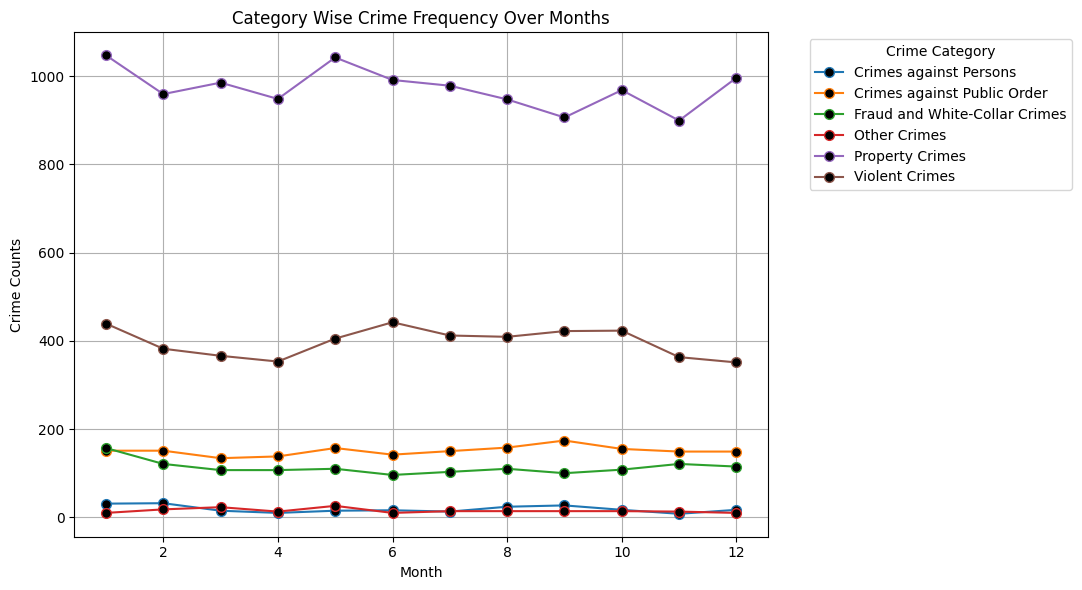

In [27]:
fig, ax = plt.subplots(figsize=(11, 6)) 
crimes_by_categories_over_months.plot(kind='line', marker='o', markersize=7, markerfacecolor='black', ax=ax)

plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Month')
plt.ylabel('Crime Counts')
plt.title('Category Wise Crime Frequency Over Months')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Insights
- January recorded the highest number of crimes, although the variation between months is relatively minor.
- Almost all types of crime show their peak in January. 

In [28]:
data["Occurred_Reported_Diff"].describe()

count    20000.000000
mean        22.120000
std        116.418619
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1437.000000
Name: Occurred_Reported_Diff, dtype: float64

In [29]:
categories_with_dates_diff = data[["Crime_Category", "Occurred_Reported_Diff"]]
min_and_max = categories_with_dates_diff.groupby("Crime_Category")["Occurred_Reported_Diff"].agg(['max', 'min'])

In [30]:
min_and_max

,max,min
Crime_Category,,
Crimes against Persons,1283,0
Crimes against Public Order,853,0
Fraud and White-Collar Crimes,1437,0
Other Crimes,339,0
Property Crimes,1324,0
Violent Crimes,1420,0


#### Insights
- The average difference between the occurrence and reporting of crimes is 22 days.
- The large value of standard deviation indicates that that the values are spread out over a wider range from the mean.
- 75% of crimes were reported within 2 days, indicating that most reported crimes have a relatively short delay between occurrence and reporting.
- The minimum difference of crime reporting is 0 in every crime category.
- Other Crimes has the least maximum difference, whereas Frauds and White Collar Crimes has largest max difference.

<a id="time-analysis"></a>
### Exploration and Analysis With Time When Crime Occurred

In [31]:
data["Time_Occurred"].value_counts()

Time_Occurred
1200.0    850
1700.0    576
1800.0    569
2000.0    529
1900.0    528
         ... 
823.0       1
237.0       1
1044.0      1
2056.0      1
259.0       1
Name: count, Length: 996, dtype: int64

The time of crime occurred is present in the form of integers, which is not that much useful. It will be better if we convert it in brackets.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


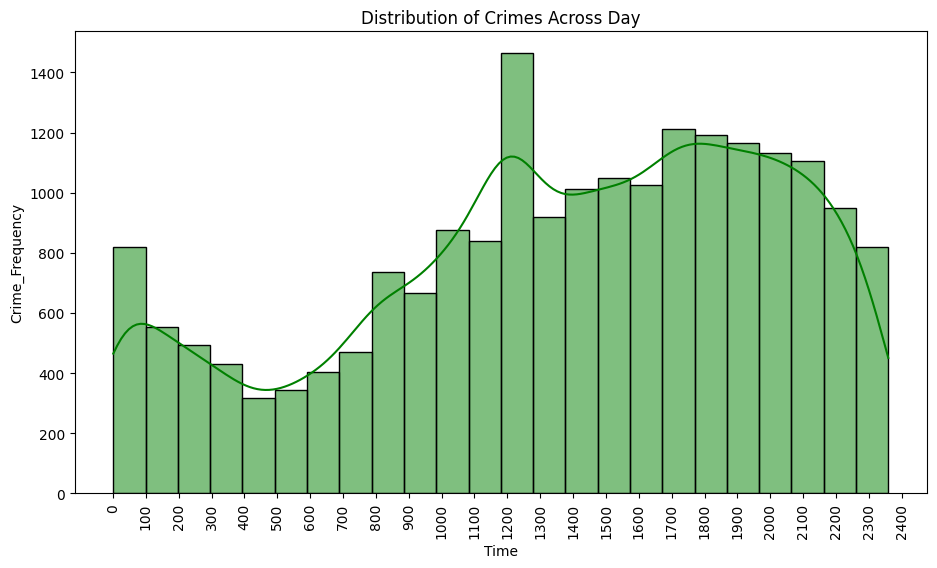

In [32]:
fig, ax = plt.subplots(figsize=(11, 6)) 
sns.histplot(data["Time_Occurred"], bins=24, color="green", kde=True, ax=ax)
plt.xlabel("Time")
plt.ylabel("Crime_Frequency")
plt.title("Distribution of Crimes Across Day")
plt.xticks(range(0, 2500, 100), rotation=90)
plt.show()

#### Insights
- The frequency of crimes is least between 4-6 AM.
- The crimes show their peak in the second half of the day, i.e from 12 pm.

I will create a new column `Time_Occurred_Range` in which I will divide 24 hr in 8 groups, i.e 0-3, 3-6, 6-9, 9-12, 12-15, 15-18, 18-21, and 21-24. This has 2 benefits:
 - The model will understand this better, as there are only 8 values.
 - I do not have to explicitly mention AM, or PM, as the time range is self-explanatory.

In [33]:
def time_occurred_range(x):
  hour = int(x)

  if hour in range(0, 300):
    return "0-3"
  elif hour in range(300, 600):
    return "3-6"
  elif hour in range(600, 900):
    return "6-9"
  elif hour in range(900, 1200):
    return "9-12"
  elif hour in range(1200,1500):
    return "12-15"
  elif hour in range(1500, 1800):
    return "15-18"
  elif hour in range(1800, 2100):
    return "18-21"
  else: return "21-24"

In [34]:
data["Time_Occurred_Range"] = data["Time_Occurred"].apply(lambda x: time_occurred_range(x))

In [35]:
data["Time_Occurred_Range"].value_counts()

Time_Occurred_Range
18-21    3490
12-15    3394
15-18    3289
21-24    2872
9-12     2384
0-3      1867
6-9      1610
3-6      1094
Name: count, dtype: int64

In [36]:
grouped_by_time = pd.crosstab(index=data['Time_Occurred_Range'], columns=data['Crime_Category'], normalize="index") * 100
grouped_by_time = grouped_by_time.reindex(index=["0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"])
grouped_by_time

Crime_Category,Crimes against Persons,Crimes against Public Order,Fraud and White-Collar Crimes,Other Crimes,Property Crimes,Violent Crimes
Time_Occurred_Range,,,,,,
0-3,0.964114,8.623460,6.373862,1.017675,56.454205,26.566685
3-6,0.639854,7.495430,2.193784,0.914077,68.007313,20.749543
6-9,1.118012,8.757764,8.571429,1.366460,58.944099,21.242236
9-12,0.964765,12.835570,9.983221,0.796980,51.887584,23.531879
12-15,1.620507,9.310548,12.787272,1.090159,52.799057,22.392457
15-18,0.972940,9.030100,6.172089,0.820918,59.501368,23.502584
18-21,1.146132,8.080229,3.724928,0.601719,63.610315,22.836676
21-24,1.114206,7.764624,2.402507,0.835655,59.644847,28.238162


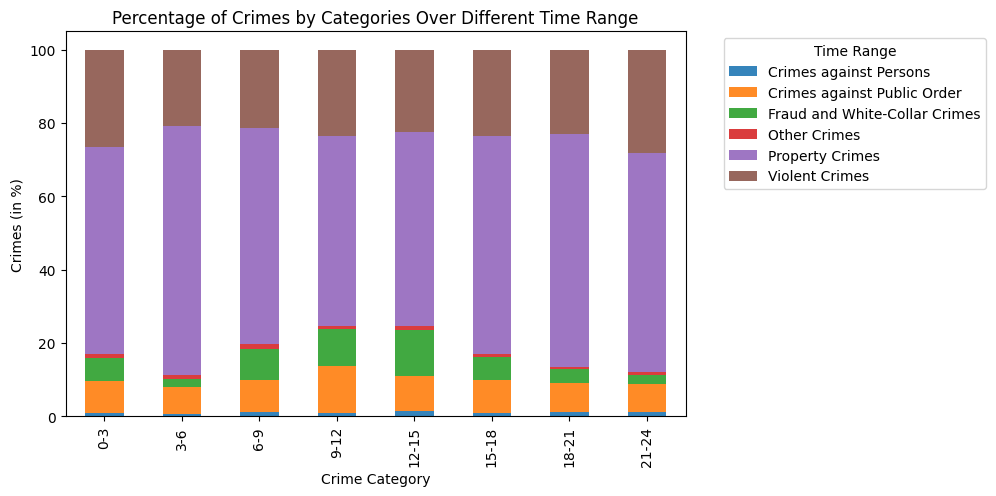

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
grouped_by_time.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)

plt.legend(title='Time Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Crime Category')
plt.ylabel('Crimes (in %)')
plt.title('Percentage of Crimes by Categories Over Different Time Range')
plt.show()

#### Insights
- Fraud and white-collar crimes predominantly occurred during business hours, aligning with expectations for such offenses.
- Most of the public order crimes took place between 9-12.
- Though crimes against person are insignificant in all time ranges, they occurred most in 12-15 noontime.
- Violent and property crimes are the most occurred crimes irrespective of time ranges.

In [38]:
data["Date_Occurred_Weekday"].value_counts()

Date_Occurred_Weekday
Friday       3010
Saturday     2932
Wednesday    2909
Thursday     2881
Tuesday      2782
Sunday       2751
Monday       2735
Name: count, dtype: int64

In [39]:
weekdays_and_time = pd.crosstab(index=data['Time_Occurred_Range'], columns=data['Date_Occurred_Weekday'])
weekdays_and_time = weekdays_and_time.reindex(index=["0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"],
                                             columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekdays_and_time

Date_Occurred_Weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Time_Occurred_Range,,,,,,,
0-3,262,238,274,248,262,264,319
3-6,142,147,143,169,137,185,171
6-9,222,249,233,242,244,226,194
9-12,320,337,378,344,324,366,315
12-15,473,481,528,489,516,480,427
15-18,458,473,463,503,537,454,401
18-21,470,476,506,475,538,531,494
21-24,388,381,384,411,452,426,430


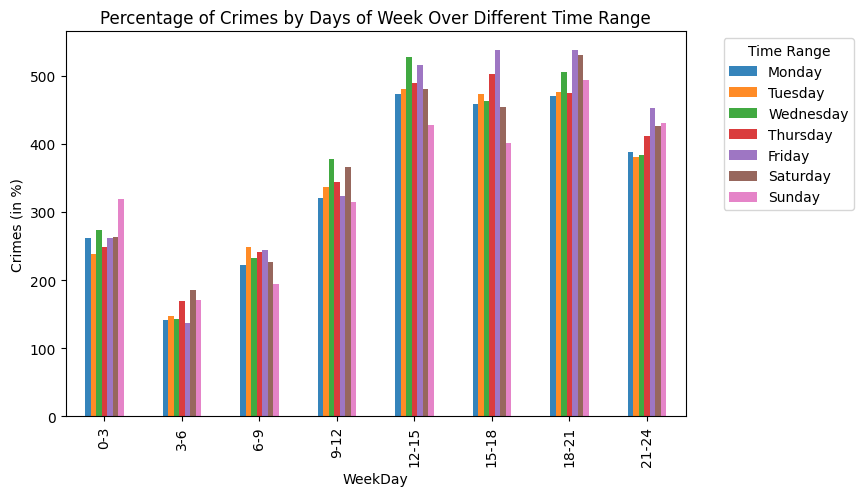

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))
weekdays_and_time.plot(kind='bar', alpha=0.9, ax=ax)

plt.legend(title='Time Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('WeekDay')
plt.ylabel('Crimes (in %)')
plt.title('Percentage of Crimes by Days of Week Over Different Time Range')
plt.show()

#### Insights
- In late-night hours (0-3), Sundays reported most number of crimes, followed by Wednesday.
- In early-mornings (3-6), crimes frequency is generally lower.
- The noon period (12-15) sees the highest number of crimes.
- After 3pm, Fridays reported most number of crimes.

<a id="victim-age-sex-descent"></a>
### Exploratrion with Victim Age, Sex, and Descent

In [41]:
data["Victim_Age"].value_counts().sort_index()

Victim_Age
-2.0        2
-1.0        4
 0.0     4828
 2.0        9
 3.0        8
         ... 
 94.0       2
 95.0       5
 96.0       2
 98.0       2
 99.0      11
Name: count, Length: 100, dtype: int64

There could be many possible values for Ages <= 0. They might represent Missing values, Not Applicable, Infants, or some kind of human errors.

**My Assumption on Victim_Age**
- If (Victim_Age is <= 0 and Victim_Sex is not given) OR (Victim_Age is < 0 and Victim_Sex is given) -> Both these conditions represent unknown values. So I will club them as X.
- If Victim_Age is 0 and Sex is given -> this clearly represent that we are talking about Infants.

In [42]:
def age_group_maker(age, sex):
    if (age <= 0 and pd.isna(sex)) or (age < 0 and not pd.isna(sex)):
        return "X"
    elif age == 0 and not pd.isna(sex):
        return "=0"
    elif age in range(1, 13):
        return "1-12"
    elif age in range(13, 18):
        return "13-17"
    elif age in range(18, 25):
        return "18-24"
    elif age in range(25, 41):
        return "25-40"
    elif age in range(41, 66):
        return "41-65"
    elif age >= 66:
        return ">65"

In [43]:
data["Victim_Age_Group"] = data.apply(lambda row: age_group_maker(row["Victim_Age"], row["Victim_Sex"]), axis=1)

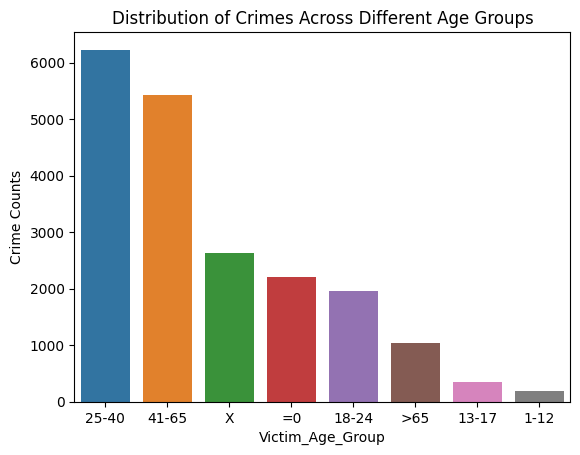

In [44]:
age_group_cat = data["Victim_Age_Group"].value_counts().index
age_group_counts = data["Victim_Age_Group"].value_counts().values
sns.barplot(x = age_group_cat, y = age_group_counts)
plt.ylabel("Crime Counts")
plt.title("Distribution of Crimes Across Different Age Groups")
plt.xticks(rotation = 0)
plt.show()

### Insights
- Most victims belongs to the Adults(25-40) age group.
- The victims are mostly from working age group, i.e Adults and Mid-Age Adults(41-65).

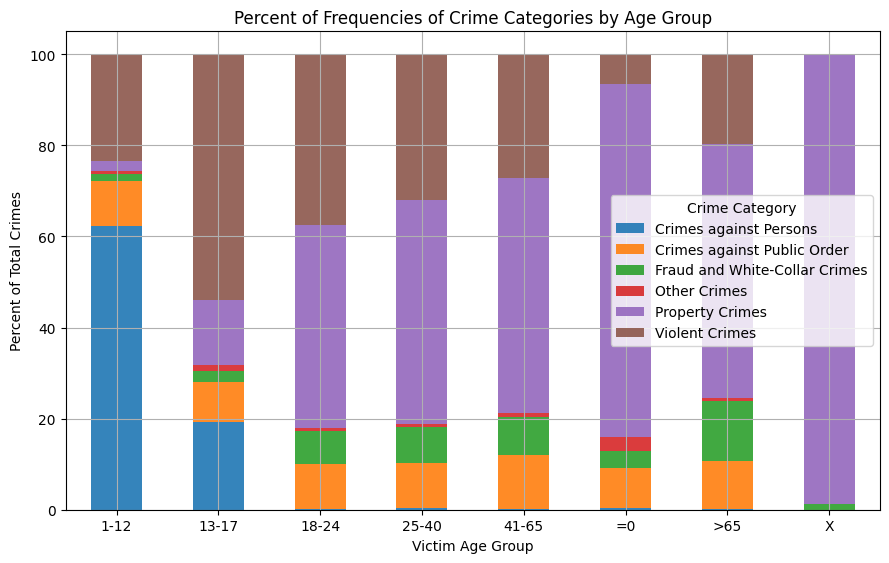

In [45]:
crimes_by_age_group = pd.crosstab(index=data["Victim_Age_Group"], columns=data["Crime_Category"], normalize="index") * 100

fig, ax = plt.subplots(figsize=(9, 6))
crimes_by_age_group.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)

plt.xlabel('Victim Age Group')
plt.ylabel('Percent of Total Crimes')
plt.title('Percent of Frequencies of Crime Categories by Age Group')
plt.legend(title='Crime Category')
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation = 0)
plt.show()

### Insights
- Crime against Persons is the most common crime among Children (1-12) age group.
- Violent Crimes is most occurring crime in Teenagers (13-17).
- Frauds and White Collar Crimes are significnt among Senior Citizens (>65). This aligns with the fact that criminals target onld age people for such crimes.

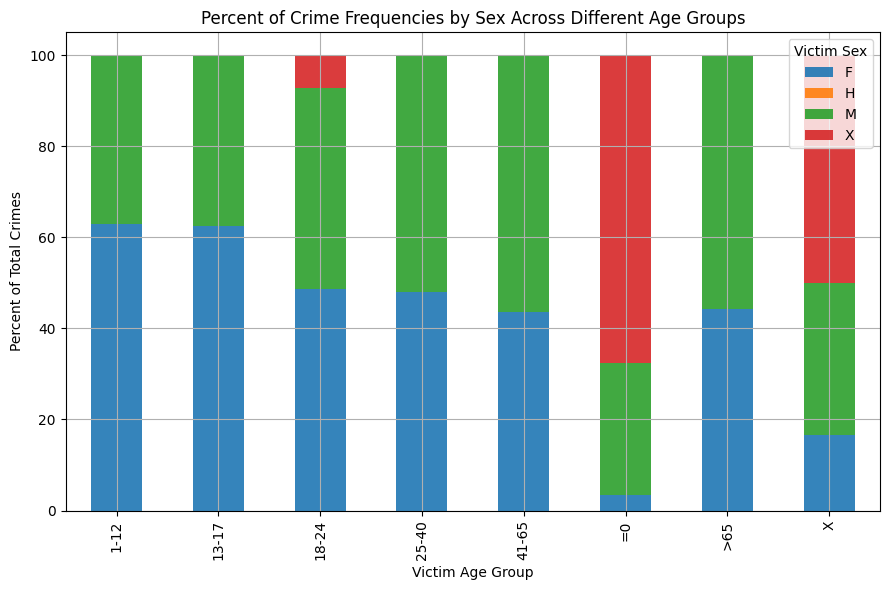

In [46]:
age_group_by_sex = pd.crosstab(index=data["Victim_Age_Group"], columns=data["Victim_Sex"], normalize="index") * 100

fig, ax = plt.subplots(figsize=(9, 6))
age_group_by_sex.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)

plt.xlabel('Victim Age Group')
plt.ylabel('Percent of Total Crimes')
plt.title('Percent of Crime Frequencies by Sex Across Different Age Groups')
plt.legend(title='Victim Sex')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Insights
- More than 60% of victims are Females in 1-12 Age group. This age group faced mostly Crime against Person and Violent Crimes.
- Similar narrative is for teenagers.
- Around 58% of victims are Males in Mid-aged adults and Senior citizens.

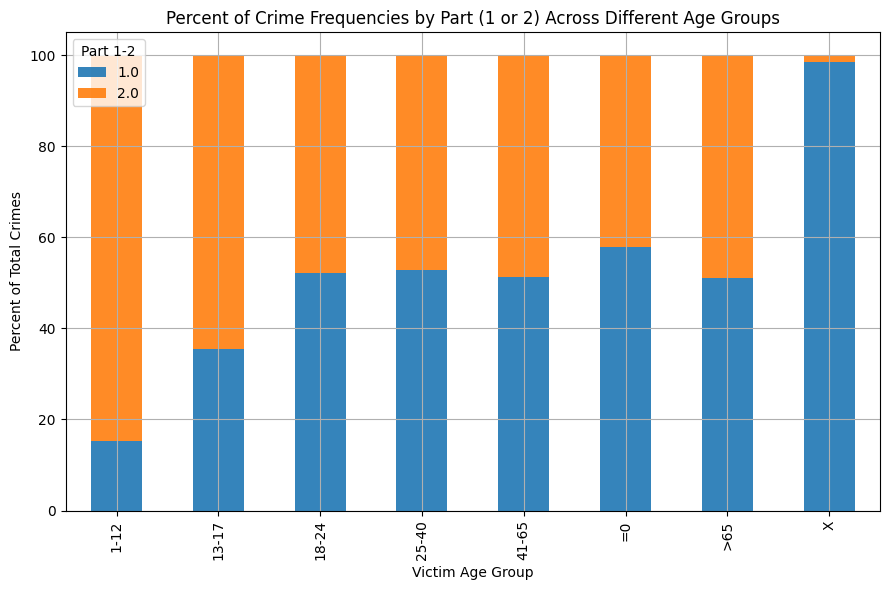

In [47]:
age_group_by_parts = pd.crosstab(index=data["Victim_Age_Group"], columns=data["Part 1-2"], normalize="index") * 100

fig, ax = plt.subplots(figsize=(9, 6))
age_group_by_parts.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)

plt.xlabel('Victim Age Group')
plt.ylabel('Percent of Total Crimes')
plt.title('Percent of Crime Frequencies by Part (1 or 2) Across Different Age Groups')
plt.legend(title='Part 1-2')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Insights
- Part II Offenses such as Drugs, Assault are common in teenagers.
- For 18-24, 25-40, 41-65, and >65 age groups -> Both Part 1 and 2 constitute 50% each.

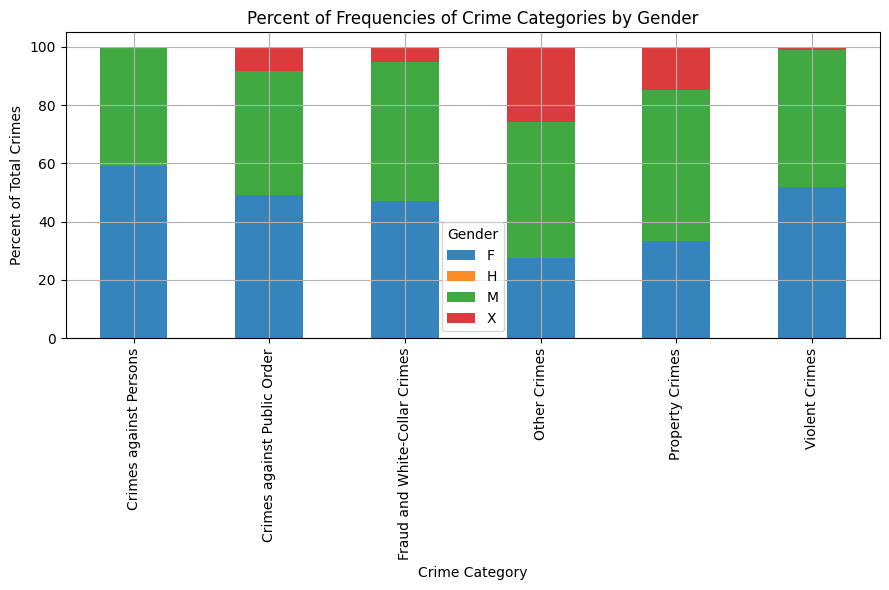

In [48]:
crimes_by_gender = pd.crosstab(index=data["Crime_Category"], columns=data["Victim_Sex"], normalize="index") * 100

fig, ax = plt.subplots(figsize=(9, 6))
crimes_by_gender.plot(kind='bar', stacked=True, alpha=0.9, ax=ax)

plt.xlabel('Crime Category')
plt.ylabel('Percent of Total Crimes')
plt.title('Percent of Frequencies of Crime Categories by Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Insights
- Females are predominantly victims in crimes against persons, public order, and violent crimes.
- In contrast, males are primarily victims in cases of fraud, property crimes, and other offenses.

In [49]:
data["Victim_Descent"].value_counts()

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

The codes in the Victim_Descent correspond to different ethnic or racial categories.

- X: Unknown
- W: White
* O: Others
- H: Hispanic
- B: Black or African American- 
- A: Asian
- K: Korean
- C: Chinese
- F: Filipino
- J: Japanese
- I: American Indian/Alaskan Native
- V: Vietnamese
- P: Pacific Islander
- Z: Asian Indian
- U: Hawaiian
- D: Cambodian
* G: Guamanian

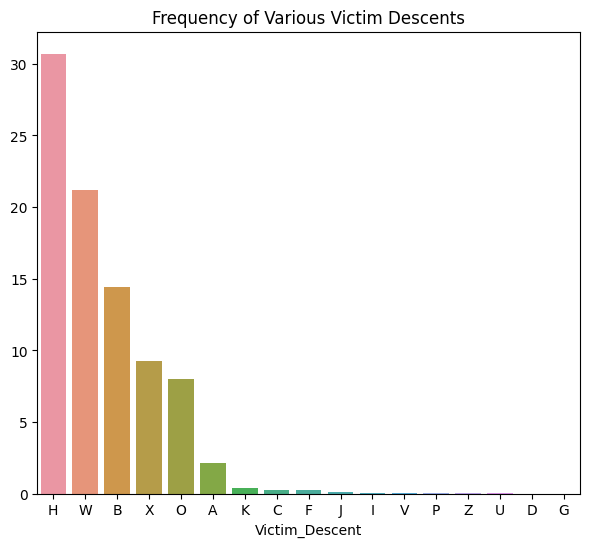

In [50]:
descent_labels = data["Victim_Descent"].value_counts().index
descent_values = data["Victim_Descent"].value_counts().values / len(data) * 100

plt.figure(figsize=(7,6))
sns.barplot(x=descent_labels, y=descent_values)
plt.title('Frequency of Various Victim Descents')
plt.show()

#### Insights
- Hispanic, Whites, and Blacks constitute around 65% of all descents

<a id="other-analysis"></a>
### Visualizing Other Features

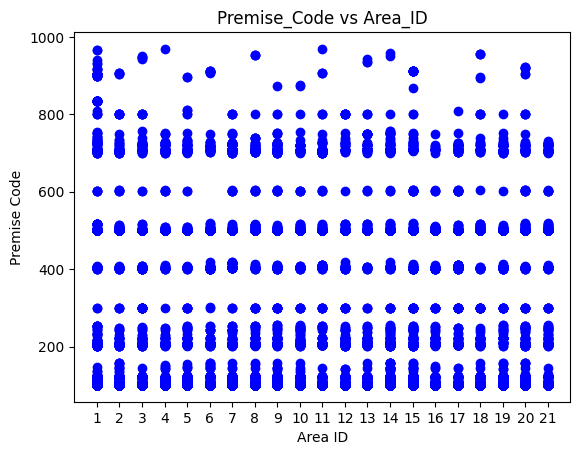

In [51]:
plt.scatter(data["Area_ID"], data["Premise_Code"], color='blue', marker='o')
plt.xlabel('Area ID')
plt.ylabel('Premise Code')
plt.title('Premise_Code vs Area_ID')
plt.xticks(sorted(data["Area_ID"].unique()))
plt.show()

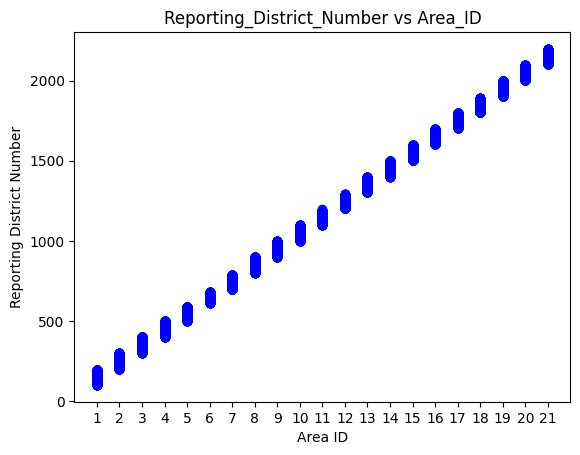

In [52]:
plt.scatter(data["Area_ID"], data["Reporting_District_no"], color='blue', marker='o')
plt.xlabel('Area ID')
plt.ylabel('Reporting District Number')
plt.title('Reporting_District_Number vs Area_ID')
plt.xticks(sorted(data["Area_ID"].unique()))
plt.show()

#### Insights
- The `Premise_Code` does not follow any distribution for a particular `Area_ID`.
- There are a fixed set of values of `Reporting_Districe_no` for each Area_ID. This makes both of them as correlated features.

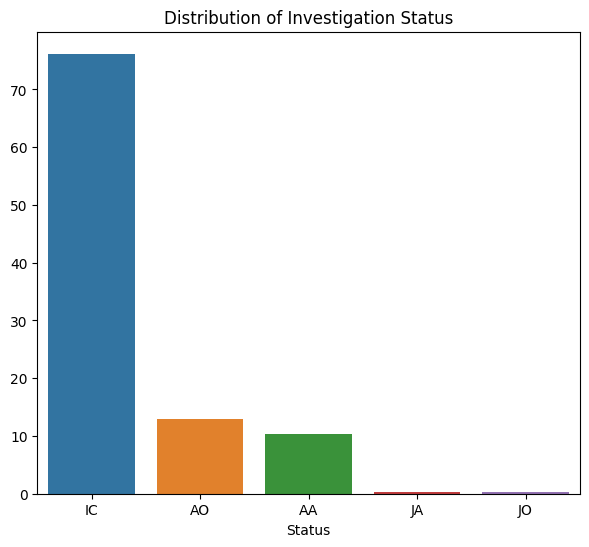

In [53]:
status_labels = data["Status"].value_counts().index
status_values = data["Status"].value_counts().values / len(data) * 100

plt.figure(figsize=(7,6))
sns.barplot(y=status_values, x=status_labels)
plt.title('Distribution of Investigation Status')
plt.show()

#### Insights
- Investigation Continued (IC) contribute around 75% of the total dataset.

<a id='data-preprocess'></a>
# Data Preprocessing

<a id="separate-feature-and-target"></a>
### Separating Features and Target Label

In [54]:
X = data.drop("Crime_Category", axis=1)
y = data["Crime_Category"]

<a id="train-test-split"></a>
### Splitting the Dataset in Train-Test Split 

In [55]:
trainX, valX, trainy, valy = train_test_split(X, y, test_size=0.2, random_state=5)

In [56]:
print("Training Data: ", trainX.shape)
print("Validation Data: ", valX.shape)

Training Data:  (16000, 26)
Validation Data:  (4000, 26)


In [57]:
trainX.isna().sum()

Location                      0
Cross_Street              13227
Latitude                      0
Longitude                     0
Date_Reported                 0
Date_Occurred                 0
Time_Occurred                 0
Area_ID                       0
Area_Name                     0
Reporting_District_no         0
Part 1-2                      0
Modus_Operandi             2193
Victim_Age                    0
Victim_Sex                 2093
Victim_Descent             2093
Premise_Code                  0
Premise_Description           3
Weapon_Used_Code          10137
Weapon_Description        10137
Status                        0
Status_Description            0
Date_Occurred_Month           0
Occurred_Reported_Diff        0
Date_Occurred_Weekday         0
Time_Occurred_Range           0
Victim_Age_Group              0
dtype: int64

In [58]:
# Let's make a copy of train dataset, to be safe.
trainXCopy = trainX.copy()

<a id="preprocess-modus-operandi"></a>
### Preprocessing `Modus_Operandi` Feature

In [59]:
trainXCopy['Modus_Operandi'] = trainXCopy['Modus_Operandi'].fillna('Others')

mo_counts = {}
total_count = 0
for mo_list in trainXCopy['Modus_Operandi']:
    for mo in mo_list.split():
        mo_counts[mo] = mo_counts.get(mo, 0) + 1
        total_count += 1

percentage_threshold = 0.001

threshold = total_count * percentage_threshold

rare_mo_codes = {mo for mo, count in mo_counts.items() if count < threshold}

# Replace rare codes with 'Others'
trainXCopy['Modus_Operandi'] = trainXCopy['Modus_Operandi'].apply(
    lambda x: ' '.join(['Others' if mo in rare_mo_codes else mo for mo in x.split()])
) 

mlb = MultiLabelBinarizer()
mlb_transformed = mlb.fit_transform(trainXCopy['Modus_Operandi'].str.split())

mlb_df = pd.DataFrame(mlb_transformed, columns=mlb.classes_)
trainXCopy.reset_index(drop=True, inplace=True)
mlb_df.reset_index(drop=True, inplace=True)

trainXCopy = pd.concat([trainXCopy.drop(columns=['Modus_Operandi']), mlb_df], axis=1)

What I have to do now:
- **Drop Columns:** [`Location`, `Cross_Street`, `Latitude`, `Longitude`, `Date_Reported`, `Date_Occurred`, `Time_Occurred`, `Area_Name`, `Victim_Age`, `Reporting_District_no`, `Premise_Description`, `Weapon_Used_Code`, `Weapon_Description`, `Status_Description`]
- **Simple Impute:** 
    - `Victim_Sex` -> "X" (X represents Unknown in the dataset)
    - `Victim_Descent` -> "X" (X represents Unknown in the dataset)

All columns of the dataset (after dropping the above columns) are **Categorical**. This means they need to be encoded. There are two popular encoding techniques - **OneHot Encoder** and **Ordinal Encoder**.<br>

Columns like `Time_Occurred_Range`, `Victim_Age_Group`, `Part 1-2` and `Date_Occurred_Weekday` can be encoded with Ordinal Encoder as these columns have certain order. <br>

`Area_ID`, and `Premise_Code` do not have any order in their values. So, I will use OneHotEncoder for these columns.

<a id="drop-columns"></a>
### Dropping Unnecessay Columns from Train Data

In [60]:
trainXCopy.drop(columns = [
    "Location", "Cross_Street", "Latitude", "Longitude", "Date_Reported", "Date_Occurred", "Time_Occurred", "Area_Name", 
    "Reporting_District_no", "Premise_Description", "Weapon_Used_Code", "Weapon_Description", "Status_Description", 
    "Victim_Age"
], axis=1, inplace=True)

<a id="custom-transformers"></a>
### Defining Custom Transformers for `Premise_Code` and `Victim_Descent`

In [61]:
class PremiseCodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_percentage=0.001):
        self.threshold_percentage = threshold_percentage
        self.common_premise_codes = None
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    def fit(self, X, y=None):
        X = self._check_input(X)
        
        counts = X.value_counts()
        threshold = len(X) * self.threshold_percentage
        self.common_premise_codes = set(counts[counts >= threshold].index)
        
        processed_X = self._process_premise(X)
        self.encoder.fit(processed_X.to_frame())
        return self

    def transform(self, X):
        X = self._check_input(X)
        processed_X = self._process_premise(X)
        return self.encoder.transform(processed_X.to_frame())

    def _check_input(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        return pd.Series(X).astype(str)

    def _process_premise(self, X):
        return X.map(lambda x: x if x in self.common_premise_codes else 'Others')

    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(['Premise_Code'])

In [62]:
class Victim_Descent_Clipper(BaseEstimator, TransformerMixin):
    def __init__(self, min_frequency=10):
        self.min_frequency = min_frequency

    def fit(self, X, y=None):
        if not isinstance(X, pd.Series):
            X = pd.Series(X.ravel())
        self.value_counts_ = X.value_counts()
        return self

    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.Series(X.ravel())
        mask = self.value_counts_ < self.min_frequency
        infrequent_categories = self.value_counts_[mask].index
        return X.replace(infrequent_categories, 'O').to_numpy().reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return np.array(['victim_descent'])

<a id="pipeline-and-column-transformer"></a>
### Defining Pipeline and ColumnTransformer

In [63]:
victim_sex_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="X")),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

victim_descent_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value="O")),
    ("clipper", Victim_Descent_Clipper(min_frequency=15)),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

transformer = ColumnTransformer(transformers=[
    ("premise_code", PremiseCodeTransformer(threshold_percentage=0.01), ["Premise_Code"]),
    ("area_id", OneHotEncoder(handle_unknown="ignore"), ["Area_ID"]),
    ("victim_sex", victim_sex_pipeline, ["Victim_Sex"]),
    ("victim_age_group", OrdinalEncoder(categories=[["X", '=0', "1-12", "13-17", "18-24", "25-40", "41-65", ">65"]]), ["Victim_Age_Group"]),
    ("victim_descent", victim_descent_pipeline, ["Victim_Descent"]),
    ("time_occurred_range", OrdinalEncoder(categories=[["0-3", "3-6", "6-9", "9-12", "12-15", "15-18", "18-21", "21-24"]]), ["Time_Occurred_Range"]),
    ('crime_occurred_weekday', OrdinalEncoder(categories=[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]), ["Date_Occurred_Weekday"]),
    ("status", OneHotEncoder(handle_unknown="ignore"), ["Status"]),
    ("occ_rep_scaler", RobustScaler(), ["Occurred_Reported_Diff"])
], remainder="passthrough", verbose_feature_names_out=False)

In [64]:
transformed = transformer.fit_transform(trainXCopy)
trf_trainXCopy = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [65]:
trf_trainXCopy.head()

,Premise_Code_101.0,Premise_Code_102.0,Premise_Code_104.0,Premise_Code_108.0,Premise_Code_122.0,Premise_Code_123.0,Premise_Code_203.0,Premise_Code_210.0,Premise_Code_501.0,Premise_Code_502.0,...,2002,2003,2004,2021,2024,2032,2033,2034,2038,Others
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
trf_trainXCopy.shape

(16000, 177)

In [67]:
trans_feature_names = transformer.get_feature_names_out()
trans_feature_names

array(['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_104.0',
       'Premise_Code_108.0', 'Premise_Code_122.0', 'Premise_Code_123.0',
       'Premise_Code_203.0', 'Premise_Code_210.0', 'Premise_Code_501.0',
       'Premise_Code_502.0', 'Premise_Code_707.0', 'Premise_Code_Others',
       'Area_ID_1.0', 'Area_ID_2.0', 'Area_ID_3.0', 'Area_ID_4.0',
       'Area_ID_5.0', 'Area_ID_6.0', 'Area_ID_7.0', 'Area_ID_8.0',
       'Area_ID_9.0', 'Area_ID_10.0', 'Area_ID_11.0', 'Area_ID_12.0',
       'Area_ID_13.0', 'Area_ID_14.0', 'Area_ID_15.0', 'Area_ID_16.0',
       'Area_ID_17.0', 'Area_ID_18.0', 'Area_ID_19.0', 'Area_ID_20.0',
       'Area_ID_21.0', 'Victim_Sex_F', 'Victim_Sex_H', 'Victim_Sex_M',
       'Victim_Sex_X', 'Victim_Age_Group', 'victim_descent_A',
       'victim_descent_B', 'victim_descent_C', 'victim_descent_F',
       'victim_descent_H', 'victim_descent_J', 'victim_descent_K',
       'victim_descent_O', 'victim_descent_W', 'victim_descent_X',
       'Time_Occurred_Rang

In [68]:
valDataCopy = valX.copy()

<a id="val-data-transform"></a>
### Transforming the Validation Data

In [69]:
def operations_on_test_data(testdf):
    testdf["Date_Reported"] = pd.to_datetime(testdf["Date_Reported"], format='%m/%d/%Y %I:%M:%S %p')
    testdf["Date_Occurred"] = pd.to_datetime(testdf["Date_Occurred"], format='%m/%d/%Y %I:%M:%S %p')
    testdf['Date_Occurred_Weekday'] = testdf["Date_Occurred"].dt.day_name()
    testdf["Date_Occurred_Month"] = testdf["Date_Occurred"].dt.month
    testdf["Occurred_Reported_Diff"] = (testdf["Date_Reported"] - testdf["Date_Occurred"]).dt.days
    testdf["Time_Occurred_Range"] = testdf["Time_Occurred"].apply(lambda x: time_occurred_range(x))

    testdf["Victim_Age_Group"] = testdf.apply(lambda row: age_group_maker(row["Victim_Age"], row["Victim_Sex"]), axis=1)
    
    testdf['Modus_Operandi'] = testdf['Modus_Operandi'].fillna('Others')
    testdf['Modus_Operandi'] = testdf['Modus_Operandi'].apply(lambda x: ' '.join(['Others' if mo in rare_mo_codes else mo for mo in x.split()]))
    mlb_test_transformed = mlb.transform(testdf['Modus_Operandi'].str.split())

    mlb_testdf = pd.DataFrame(mlb_test_transformed, columns=mlb.classes_)

    testdf.reset_index(drop=True, inplace=True)
    mlb_testdf.reset_index(drop=True, inplace=True)

    testdf = pd.concat([testdf.drop(columns=['Modus_Operandi']), mlb_testdf], axis=1)

    testdf.drop(columns = [
        "Location", "Cross_Street", "Latitude", "Longitude", "Date_Reported", "Date_Occurred", "Time_Occurred", "Area_Name", "Reporting_District_no",
        "Premise_Description", "Weapon_Used_Code", "Weapon_Description", "Status_Description", "Victim_Age"
    ], axis=1, inplace=True)

    return testdf

In [70]:
valDataCopy_preprocessed = operations_on_test_data(valDataCopy)
val_transformed = transformer.transform(valDataCopy_preprocessed)
val_trf = pd.DataFrame(val_transformed, columns=transformer.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0117', '0328', '0364', '0372', '0425', '0434', '0544', '0557', '0851', '0855', '0859', '0902', '0938', '0946', '1229', '1232', '1233', '1410', '1520', '2011', '2020', '2056', '2104', '2157', '3003'] will be ignored
  warnings.warn(


<a id="logit"></a>
# Logistic Regression (Model 1)

<a id="base-logit"></a>
#### Fitting Base Logistic Regression Model

In [71]:
# Base Logistic Regression Model with default prameter values.

logit = LogisticRegression(solver = "newton-cg", 
                           multi_class = "multinomial", 
                           max_iter = 2000,
                           n_jobs=-1,
                           random_state = 5)

logit.fit(trf_trainXCopy, trainy)

LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=-1,
                   random_state=5, solver='newton-cg')

In [72]:
# Prediction on Validation Data Using Base Logitic Regression Model
base_logit_val_prediction = logit.predict(val_trf)

base_logit_train_acc = logit.score(trf_trainXCopy, trainy)
base_logit_val_acc = accuracy_score(valy, base_logit_val_prediction)

print("Training Accuracy: ", base_logit_train_acc)
print("Validation Accuracy: ", base_logit_val_acc)

Training Accuracy:  0.9530625
Validation Accuracy:  0.93825


<a id="base-logit-insights"></a>
#### Insight with Base Logistic Regression Model

I am getting **training score of 95.3%** and **validation score of 93.8%**. The base model is performing well, and is not overfitting.
Let us check the consistency of the base logistics regression model with cross-validation.

As my dataset is imbalanced, I will be using *Stratified K-Fold Cross-Validation*.

In [73]:
base_logit_with_skf = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

scores = cross_val_score(estimator = logit, 
                         X = trf_trainXCopy, 
                         y = trainy, 
                         cv = base_logit_with_skf, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.940625  0.9425    0.9440625 0.9365625 0.945    ]
Stratified K-Fold Scores (Mean):  0.9417500000000001
Stratified K-Fold Scores (Std Dev):  0.0029882582719704827


<a id="insight-base-logit-cv"></a>
#### Insights on Cross-Validation on Base Logit Model

* **Stratified K-Fold Scores:**  [0.940625  0.9425    0.9440625 0.9365625 0.945    ]
* **Stratified K-Fold Scores (Mean):**  0.9417500000000001
* **Stratified K-Fold Scores (Std Dev):**  0.0029882582719704827
- The mean cross-validation score of 94.1% is very close to the training accuracy (with base model) 95.3% indicating consistency in model performance across different folds.
- The standard deviation is low i.e 0.003, showing that the model's performance is stable across different subsets of the data.

In [74]:
# logit_param_grid = {
#     'C': [0.8, 0.9],
#     'tol': [1e-6, 1e-5],
#     "fit_intercept": [True, False]
# }

# logit_grid_search = GridSearchCV(estimator=LogisticRegression(solver="newton-cg", 
#                                                               max_iter=4000, 
#                                                               multi_class="multinomial",
#                                                               warm_start=True,
#                                                               n_jobs=-1,
#                                                               random_state=5), 
#                                  param_grid=logit_param_grid,
#                                  cv=5,
#                                  verbose=1,
#                                  scoring='accuracy', 
#                                  n_jobs=-1)

# logit_grid_search.fit(trf_trainXCopy, trainy)

In [75]:
# logit_best_model = logit_grid_search.best_estimator_
# logit_best_params = logit_grid_search.best_params_
# print("Best Parameters for Logit Model: ", logit_best_params)
# print("Mean Cross-Validated Score of Best Estimator: ", logit_grid_search.best_score_)

In [76]:
logit_best_params = {'C': 0.9, 'fit_intercept': True, 'tol': 1e-06}

logit_best_model = LogisticRegression(solver="newton-cg", 
                   max_iter=4000, 
                   multi_class="multinomial", 
                   warm_start=True, 
                   n_jobs=-1,
                   random_state=5,
                   **logit_best_params)

logit_best_model.fit(trf_trainXCopy, trainy)

LogisticRegression(C=0.9, max_iter=4000, multi_class='multinomial', n_jobs=-1,
                   random_state=5, solver='newton-cg', tol=1e-06,
                   warm_start=True)

In [77]:
# Logit model accuracy with tuned parameters

best_logit_val_predictions = logit_best_model.predict(val_trf)
best_logit_train_acc = logit_best_model.score(trf_trainXCopy, trainy)
best_logit_val_acc = accuracy_score(valy, best_logit_val_predictions)

print("Training Accuracy: ", best_logit_train_acc)
print("Validation Accuracy: ", best_logit_val_acc)

Training Accuracy:  0.953
Validation Accuracy:  0.9385


<a id="insight-tuning-logit"></a>
#### Insights Of Hyper-Parameter Tuning on Logistic Regression Model

- **Best Parameters for Logit Model:**  *{'C': 0.9, 'fit_intercept': True, 'tol': 1e-06}*
- **Mean Cross-Validated Score of Best Estimator:**  *0.9416874999999999*
<br>
- **Training Accuracy:**  *0.953*
- **Validation Accuracy:**  *0.9385*
<br>
The training and validation accuracy is not at all increased.

In [78]:
# Searching for best features using best logit model.

# logit_with_rfe = RFE(logit_best_model, n_features_to_select=150)
# logit_with_rfe.fit(trf_trainXCopy, trainy)

# selected_features_with_rfe = trf_trainXCopy.columns[logit_with_rfe.support_]
# print("Selected features:", selected_features_with_rfe)

# logit_with_rfe.fit(trf_trainXCopy[selected_features_with_rfe], trainy)
# logit_rfe_val_predictions = logit_with_rfe.predict(val_trf[selected_features_with_rfe])

# logit_rfe_train_acc = logit_with_rfe.score(trf_trainXCopy[selected_features_with_rfe], trainy)
# logit_rfe_val_acc = accuracy_score(valy, logit_rfe_val_predictions)
# print("Training Accuracy: ", logit_rfe_train_acc)
# print("Validation Accuracy: ", logit_rfe_val_acc)

# logit_with_rfe.get_params()

<a id="insight-rfe-logit"></a>
#### Insights of Logistic Regression Model With RFE Feature Selection

I used the above code-block with different `n_features_to_select` values, and noted down the selected features, training, and validation scores.

**50 Selected Features**<br>['Premise_Code_122.0', 'Victim_Sex_X', 'victim_descent_X', 'Status_AA',
       'Status_AO', 'Part 1-2', '0100', '0302', '0305', '0325', '0329', '0334',
       '0337', '0344', '0355', '0356', '0377', '0400', '0408', '0411', '0416',
       '0417', '0421', '0430', '0431', '0443', '0444', '0445', '0446', '0447',
       '0448', '0450', '0500', '0522', '0527', '0701', '0800', '0922', '0928',
       '0929', '0930', '1100', '1212', '1218', '1258', '1259', '1606', '1906',
       '2000', '2038']<br>
       
**100 Selected Features:**<br> ['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_122.0',
       'Area_ID_17.0', 'Victim_Sex_X', 'victim_descent_X', 'Status_AA',
       'Status_AO', 'Status_JA', 'Part 1-2', '0100', '0202', '0209', '0216',
       '0302', '0305', '0311', '0314', '0321', '0325', '0329', '0334', '0337',
       '0340', '0342', '0344', '0346', '0352', '0355', '0356', '0358', '0361',
       '0377', '0385', '0394', '0400', '0401', '0408', '0411', '0416', '0417',
       '0419', '0421', '0429', '0430', '0431', '0443', '0444', '0445', '0446',
       '0447', '0448', '0450', '0500', '0522', '0527', '0554', '0561', '0603',
       '0701', '0800', '0906', '0910', '0913', '0917', '0922', '0928', '0929',
       '0930', '0945', '1100', '1202', '1212', '1218', '1243', '1251', '1258',
       '1259', '1302', '1309', '1402', '1407', '1414', '1501', '1606', '1607',
       '1609', '1814', '1816', '1820', '1822', '1906', '2000', '2004', '2024',
       '2032', '2033', '2034', '2038', 'Others']<br>

**150 Selected Features** <br> ['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_104.0',
       'Premise_Code_122.0', 'Premise_Code_123.0', 'Premise_Code_203.0',
       'Premise_Code_210.0', 'Premise_Code_501.0', 'Premise_Code_502.0',
       'Premise_Code_707.0', 'Premise_Code_Others', 'Area_ID_1.0',
       'Area_ID_2.0', 'Area_ID_6.0', 'Area_ID_8.0', 'Area_ID_9.0',
       'Area_ID_10.0', 'Area_ID_11.0', 'Area_ID_12.0', 'Area_ID_13.0',
       'Area_ID_14.0', 'Area_ID_15.0', 'Area_ID_16.0', 'Area_ID_17.0',
       'Area_ID_18.0', 'Area_ID_20.0', 'Victim_Sex_F', 'Victim_Sex_M',
       'Victim_Sex_X', 'Victim_Age_Group', 'victim_descent_A',
       'victim_descent_B', 'victim_descent_H', 'victim_descent_X', 'Status_AA',
       'Status_AO', 'Status_IC', 'Status_JA', 'Status_JO', 'Part 1-2', '0100',
       '0202', '0209', '0216', '0302', '0305', '0311', '0314', '0319', '0321', 
       '0325', '0329', '0334', '0337', '0340', '0342', '0344', '0346',
       '0352', '0355', '0356', '0358', '0360', '0361', '0371', '0377', '0385',
       '0394', '0400', '0401', '0408', '0411', '0416', '0417', '0419', '0421',
       '0429', '0430', '0431', '0432', '0443', '0444', '0445', '0446', '0447',
       '0448', '0450', '0500', '0522', '0527', '0554', '0561', '0601', '0602',
       '0603', '0701', '0800', '0906', '0910', '0913', '0917', '0922', '0928', 
       '0929', '0930', '0945', '1100', '1202', '1206', '1212', '1218', '1236', 
       '1243', '1251', '1258', '1259', '1266', '1300', '1302', '1307', '1309', 
       '1310', '1402', '1407', '1414', '1419', '1420', '1501', '1601', '1606', 
       '1607', '1609', '1813', '1814', '1816', '1817', '1820', '1821', '1822', 
       '1906', '2000', '2003', '2004', '2021', '2024', '2032', '2033', '2034', '2038', 'Others']

**Scores With 50 RFE Features:**
- Training Accuracy:  0.9346 (93.46%)
- Validation Accuracy:  0.9295 (92.95%)

**Scores With 100 RFE Features:**
- Training Accuracy:  0.9463125 (94.63%)
- Validation Accuracy:  0.9355 (93.55%)

**Scores With 150 RFE Features:**
- Training Accuracy:  0.9508 (95.08%)
- Validation Accuracy:  0.93675 (93.68%)

**Scores With All Features:**
- Training Accuracy:  0.953 (95.3%)
- Validation Accuracy:  0.9385 (93.85%)

**Insights:**
- The validation accuracy with 100 features is very close to the accuracy with all 263 features. This implies that the top 100 features selected by RFE capture most of the important information needed for the model.
- This is beneficial as it simplifies the model, reduces computation time, and enhances interpretability without sacrificing much accuracy.
- The gap between training and validation accuracy is small across all feature sets, which suggests that the model is not overfitting.
- The scores with 50 features is lowest. It means model is not capturing enough information with 50 features.

Finally, I'll go with 100 features for my Logistic Regression model.


In [79]:
logit_selected_100_features = ['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_122.0', 
                               'Area_ID_17.0', 'Victim_Sex_X', 'victim_descent_X', 'Status_AA', 'Status_AO', 
                               'Status_JA', 'Part 1-2', '0100', '0202', '0209', '0216', '0302', '0305', '0311', 
                               '0314', '0321', '0325', '0329', '0334', '0337', '0340', '0342', '0344', '0346', 
                               '0352', '0355', '0356', '0358', '0361', '0377', '0385', '0394', '0400', '0401', 
                               '0408', '0411', '0416', '0417', '0419', '0421', '0429', '0430', '0431', '0443', 
                               '0444', '0445', '0446', '0447', '0448', '0450', '0500', '0522', '0527', '0554', 
                               '0561', '0603', '0701', '0800', '0906', '0910', '0913', '0917', '0922', '0928', 
                               '0929', '0930', '0945', '1100', '1202', '1212', '1218', '1243', '1251', '1258', 
                               '1259', '1302', '1309', '1402', '1407', '1414', '1501', '1606', '1607', '1609', 
                               '1814', '1816', '1820', '1822', '1906', '2000', '2004', '2024', '2032', '2033', 
                               '2034', '2038', 'Others']

In [80]:
logit_best_model = LogisticRegression(solver="newton-cg", 
                   max_iter=4000, 
                   multi_class="multinomial", 
                   warm_start=True, 
                   n_jobs=-1,
                   random_state=5,
                   **logit_best_params)

logit_best_model.fit(trf_trainXCopy[logit_selected_100_features], trainy)

# Logit model accuracy after feature selection

best_logit_val_predictions_fs = logit_best_model.predict(val_trf[logit_selected_100_features])
best_logit_train_acc_fs = logit_best_model.score(trf_trainXCopy[logit_selected_100_features], trainy)
best_logit_val_acc_fs = accuracy_score(valy, best_logit_val_predictions_fs)

print("Training Accuracy: ", best_logit_train_acc_fs)
print("Validation Accuracy: ", best_logit_val_acc_fs)

Training Accuracy:  0.9463125
Validation Accuracy:  0.9355


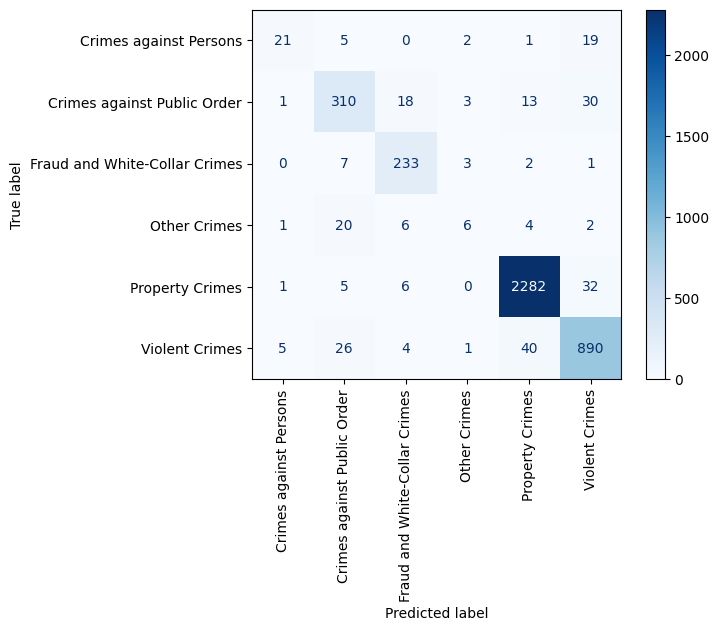

In [81]:
cm = confusion_matrix(valy, best_logit_val_predictions_fs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = logit_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

Now, I will use Stratified K-Fold Cross Validation to check if my model, with selected 100 features, is performing well on different folds of the data.

In [82]:
report = classification_report(valy, best_logit_val_predictions_fs, target_names=logit_best_model.classes_)
print(report)

                               precision    recall  f1-score   support

       Crimes against Persons       0.72      0.44      0.55        48
  Crimes against Public Order       0.83      0.83      0.83       375
Fraud and White-Collar Crimes       0.87      0.95      0.91       246
                 Other Crimes       0.40      0.15      0.22        39
              Property Crimes       0.97      0.98      0.98      2326
               Violent Crimes       0.91      0.92      0.92       966

                     accuracy                           0.94      4000
                    macro avg       0.79      0.71      0.73      4000
                 weighted avg       0.93      0.94      0.93      4000



<a id="classification-logit"></a>
#### Classification Report Insights

- The Logistic Regression model is performing well for Crimes against Public Order, Fraud and White Collar Crimes, Property Crimes, and Violent Crimes.
- The model is facing difficulty in predicting Crimes against Persons, and especially Other Crimes.
- This could be due to the reason that these classes are under-represented in the training dataset.

In [83]:
skf_logit_with_100_features = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

skf_logit_scores_with_100_features = cross_val_score(estimator = logit_best_model, 
                         X = trf_trainXCopy[logit_selected_100_features], 
                         y = trainy, 
                         cv = skf_logit_with_100_features, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", skf_logit_scores_with_100_features)
print("Stratified K-Fold Scores (Mean): ", np.mean(skf_logit_scores_with_100_features))
print("Stratified K-Fold Scores (Std Dev): ", np.std(skf_logit_scores_with_100_features))

Stratified K-Fold Scores:  [0.9384375 0.944375  0.9446875 0.935625  0.9446875]
Stratified K-Fold Scores (Mean):  0.9415625000000001
Stratified K-Fold Scores (Std Dev):  0.0038068605832102457


<a id="logit-final"></a>
#### Logistic Regression Model Final Interpretations

- **Stratified K-Fold Scores:**  *[0.9384375 0.944375  0.9446875 0.935625  0.9446875]*
- **Stratified K-Fold Scores (Mean):**  *0.9415625000000001*
- **Stratified K-Fold Scores (Std Dev):**  *0.0038068605832102457*
<br>
- The mean cross-validation score (with 100 features) of 0.9415 (94.15%) is very close to the overall training accuracy (with 100 features) of 0.9463 (94.63%). This indicates that the model's performance is consistent across different folds.
- Low standard deviation of 0.0035 suggests that the model's performance is stable and does not vary much across different folds.

<a id="dtree"></a>
# Decision Tree Classifier (Model 2)

In [84]:
# Base Decision Tree Classifier With Default Params.

dtree = DecisionTreeClassifier(random_state=5)
dtree.fit(trf_trainXCopy, trainy)

DecisionTreeClassifier(random_state=5)

In [85]:
# Prediction on Validation Data Using Base Decision Tree Classifier
base_dtree_val_predictions = dtree.predict(val_trf)

base_dtree_train_acc = dtree.score(trf_trainXCopy, trainy)
base_dtree_val_acc = accuracy_score(valy, base_dtree_val_predictions)

print("Training Accuracy: ", base_dtree_train_acc)
print("Validation Accuracy: ", base_dtree_val_acc)

Training Accuracy:  1.0
Validation Accuracy:  0.91575


In [86]:
base_dtree_with_skf = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

scores = cross_val_score(estimator = dtree, 
                         X = trf_trainXCopy, 
                         y = trainy, 
                         cv = base_dtree_with_skf, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.92      0.9240625 0.92125   0.91125   0.9228125]
Stratified K-Fold Scores (Mean):  0.919875
Stratified K-Fold Scores (Std Dev):  0.00452682974055796


<a id="insight-base-dtree-cv"></a>
#### Insights on Base Decision Tree Classifier Along With Cross Validation

- **Stratified K-Fold Scores:**  *[0.92      0.9240625 0.92125   0.91125   0.9228125]*
- **Stratified K-Fold Scores (Mean):**  *0.919875*
- **Stratified K-Fold Scores (Std Dev):**  *0.00452682974055796*
<br>
- The stratiifed cross-validation scores are in range of 91-92%, but the model score on whole dataset is perfect 1.0
- This indicates that my base dtree model is slightly overfitting because when I use cross-validation, each fold is a slightly different subset of the data, and the model's performance drops because it hasn’t seen this exact configuration of data before.

In [87]:
dtree.get_depth()

55

In [88]:
# dtree_param_grid = {
#     "criterion": ["gini", "entropy", "log_loss"],
#     "splitter":  ["best", "random"],
#     "class_weight": [None, "balanced"],
#     "max_depth": [46, 48, 52],
#     "min_samples_split": [10, 15, 20],
#     "min_samples_leaf": [3, 5, 10],
# }

# dtree_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(max_features=None, random_state=5), 
#                                  param_grid=dtree_param_grid,
#                                  cv=5,
#                                  verbose=1,
#                                  scoring='accuracy', 
#                                  n_jobs=-1)

# dtree_grid_search.fit(trf_trainXCopy, trainy)

In [89]:
# dtree_best_model = dtree_grid_search.best_estimator_
# dtree_best_params = dtree_grid_search.best_params_
# print("Best Parameters for Decision Tree Model: ", dtree_best_params)
# print("Mean Cross-Validated Score of Best Estimator: ", dtree_grid_search.best_score_)

In [90]:
dtree_best_params = {'ccp_alpha': 0.0001,
                     'class_weight': None,
                     'criterion': 'gini', 
                     'max_depth': 48, 
                     'min_samples_leaf': 3, 
                     'min_samples_split': 10, 
                     'splitter': 'random'}

dtree_best_model = DecisionTreeClassifier(max_features=None, 
                                          random_state=5,
                                          **dtree_best_params)

dtree_best_model.fit(trf_trainXCopy, trainy)

DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=48, min_samples_leaf=3,
                       min_samples_split=10, random_state=5, splitter='random')

In [91]:
# Decision Tree Model accuracy with tuned parameters

best_dtree_val_predictions = dtree_best_model.predict(val_trf)
best_dtree_train_acc = dtree_best_model.score(trf_trainXCopy, trainy)
best_dtree_val_acc = accuracy_score(valy, best_dtree_val_predictions)

print("Training Accuracy: ", best_dtree_train_acc)
print("Validation Accuracy: ", best_dtree_val_acc)

Training Accuracy:  0.957625
Validation Accuracy:  0.92475


<a id="insights-tuning-dtree"></a>
#### Insights of Hyper-Parameter Tuning on Decision Tree Classifier

- **Best Parameters for Decision Tree Model:**  *{'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 10, 'splitter': 'random'}*
- **Mean Cross-Validated Score of Best Estimator:**  *0.9319375000000001*
<br>
- With tuned parameters, I am getting the training accuracy of 95.76%, which is lower that previous perfect 100%. This indicates that the model is no longer overfitting, and generalizing well on training data.
- The current validation accracy of 92.48% is slightly higher than the previous validation accuracy of 91.56%, indicating improved generalization to unseen data.

In [92]:
# # Searching for best features using best decision tree model.
# n_features_to_select = [30, 50, 100, 150]
# for i in n_features_to_select:
#     dtree_with_rfe = RFE(dtree_best_model, n_features_to_select=i)
#     dtree_with_rfe.fit(trf_trainXCopy, trainy)
    
#     selected_features_with_rfe = trf_trainXCopy.columns[dtree_with_rfe.support_]
    
#     dtree_with_rfe.fit(trf_trainXCopy[selected_features_with_rfe], trainy)
#     dtree_rfe_val_predictions = dtree_with_rfe.predict(val_trf[selected_features_with_rfe])
    
#     dtree_rfe_train_acc = dtree_with_rfe.score(trf_trainXCopy[selected_features_with_rfe], trainy)
#     dtree_rfe_val_acc = accuracy_score(valy, dtree_rfe_val_predictions)
    
#     print(f"Scores With {i} Features:")
#     print("Training Accuracy: ", dtree_rfe_train_acc)
#     print("Validation Accuracy: ", dtree_rfe_val_acc)

<a id="insight-rfe-dtree"></a>
#### Insights of Decision Tree Classifier With RFE Feature Selection

I used the above code-block with different `n_features_to_select` values, and noted down the selected features, training, and validation scores.

**50 RFE Selected Features**<br>['Premise_Code_101.0', 'Premise_Code_501.0', 'Premise_Code_502.0',
       'Victim_Sex_X', 'Victim_Age_Group', 'Status_IC',
       'Occurred_Reported_Diff', 'Part 1-2', '0100', '0302', '0325', '0329',
       '0334', '0337', '0344', '0355', '0356', '0377', '0385', '0394', '0400',
       '0411', '0416', '0417', '0421', '0430', '0443', '0444', '0445', '0446',
       '0447', '0448', '0522', '0527', '0701', '0913', '0930', '1100', '1243',
       '1258', '1259', '1501', '1607', '1609', '1822', '1906', '2000', '2004',
       '2038', 'Others']
       
**100 RFE Selected Features**<br>['Premise_Code_101.0', 'Premise_Code_108.0', 'Premise_Code_122.0',
       'Premise_Code_123.0', 'Premise_Code_203.0', 'Premise_Code_210.0',
       'Premise_Code_501.0', 'Premise_Code_502.0', 'Premise_Code_707.0',
       'Premise_Code_Others', 'Area_ID_1.0', 'Area_ID_2.0', 'Area_ID_3.0',
       'Area_ID_4.0', 'Area_ID_5.0', 'Area_ID_6.0', 'Area_ID_7.0',
       'Area_ID_8.0', 'Area_ID_9.0', 'Area_ID_10.0', 'Area_ID_13.0',
       'Area_ID_18.0', 'Victim_Sex_F', 'Victim_Sex_M', 'Victim_Sex_X',
       'Victim_Age_Group', 'victim_descent_H', 'victim_descent_W',
       'Time_Occurred_Range', 'Date_Occurred_Weekday', 'Status_AA',
       'Status_AO', 'Status_IC', 'Occurred_Reported_Diff', 'Part 1-2', '0100',
       '0302', '0325', '0329', '0334', '0337', '0340', '0342', '0344', '0346',
       '0352', '0355', '0356', '0377', '0385', '0394', '0400', '0408', '0411',
       '0416', '0417', '0419', '0421', '0430', '0432', '0443', '0444', '0445',
       '0446', '0447', '0448', '0450', '0522', '0527', '0701', '0800', '0913',
       '0922', '0928', '0929', '0930', '1100', '1212', '1218', '1243', '1258',
       '1259', '1300', '1302', '1402', '1420', '1501', '1606', '1607', '1609',
       '1810', '1821', '1822', '1906', '2000', '2004', '2024', '2033', '2038',
       'Others']
       
**150 RFE Selected Features**<br>['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_104.0',
       'Premise_Code_108.0', 'Premise_Code_122.0', 'Premise_Code_123.0',
       'Premise_Code_203.0', 'Premise_Code_210.0', 'Premise_Code_501.0',
       'Premise_Code_502.0', 'Premise_Code_707.0', 'Premise_Code_Others',
       'Area_ID_1.0', 'Area_ID_2.0', 'Area_ID_3.0', 'Area_ID_4.0',
       'Area_ID_5.0', 'Area_ID_6.0', 'Area_ID_7.0', 'Area_ID_8.0',
       'Area_ID_9.0', 'Area_ID_10.0', 'Area_ID_11.0', 'Area_ID_12.0',
       'Area_ID_13.0', 'Area_ID_14.0', 'Area_ID_15.0', 'Area_ID_16.0',
       'Area_ID_17.0', 'Area_ID_18.0', 'Area_ID_19.0', 'Area_ID_20.0',
       'Area_ID_21.0', 'Victim_Sex_F', 'Victim_Sex_M', 'Victim_Sex_X',
       'Victim_Age_Group', 'victim_descent_B', 'victim_descent_C',
       'victim_descent_F', 'victim_descent_H', 'victim_descent_J',
       'victim_descent_K', 'victim_descent_O', 'victim_descent_W',
       'Time_Occurred_Range', 'Date_Occurred_Weekday', 'Status_AA',
       'Status_AO', 'Status_IC', 'Status_JA', 'Occurred_Reported_Diff',
       'Part 1-2', 'Date_Occurred_Month', '0100', '0216', '0302', '0325',
       '0329', '0334', '0337', '0340', '0342', '0344', '0345', '0346', '0352',
       '0355', '0356', '0358', '0360', '0361', '0371', '0377', '0385', '0394',
       '0397', '0400', '0401', '0408', '0411', '0416', '0417', '0419', '0421',
       '0429', '0430', '0431', '0432', '0443', '0444', '0445', '0446', '0447',
       '0448', '0450', '0500', '0522', '0527', '0554', '0561', '0601', '0602', 
       '0603', '0701', '0800', '0906', '0913', '0917', '0922', '0928', '0929', 
       '0930', '1100', '1212', '1218', '1243', '1258', '1259', '1266', '1300', 
       '1302', '1307', '1309', '1310', '1402', '1407', '1414', '1419', '1420', 
       '1501', '1602', '1605', '1606', '1607', '1609', '1810', '1813', '1814', 
       '1820', '1821', '1822', '1906', '2000', '2004', '2021', '2024', '2033', 
       '2038', 'Others']
       
       
**Scores With 30 Features:**
- Training Accuracy:  0.9343125
- Validation Accuracy:  0.9175

**Scores With 50 Features:**
- Training Accuracy:  0.950125
- Validation Accuracy:  0.929

**Scores With 100 Features:**
- Training Accuracy:  0.9573
- Validation Accuracy:  0.926

**Scores With 150 Features:**
- Training Accuracy:  0.959
- Validation Accuracy:  0.927

**Scores With All Features:**
- Training Accuracy:  0.957625
- Validation Accuracy:  0.92475

**Insights**
- The training and validation accuracies are quite similar across different feature sets. This suggests that the model's performance is robust to the number of features selected.
- The model performs well even with just 50 features suggests that these features are capturing the most important information needed for the model to make accurate predictions.

Finally, I'll go with 50 features for my Decision Tree Classifier model.

In [93]:
dtree_selected_50_features = ['Premise_Code_101.0', 'Premise_Code_501.0', 'Premise_Code_502.0', 'Victim_Sex_X', 
                              'Victim_Age_Group', 'Status_IC', 'Occurred_Reported_Diff', 'Part 1-2', '0100', '0302', 
                              '0325', '0329', '0334', '0337', '0344', '0355', '0356', '0377', '0385', '0394', '0400', 
                              '0411', '0416', '0417', '0421', '0430', '0443', '0444', '0445', '0446', '0447', '0448', 
                              '0522', '0527', '0701', '0913', '0930', '1100', '1243', '1258', '1259', '1501', '1607', 
                              '1609', '1822', '1906', '2000', '2004', '2038', 'Others']

In [94]:
# Decision Tree Model accuracy after feature selection
dtree_best_model = DecisionTreeClassifier(max_features=None, 
                                          random_state=5,
                                          **dtree_best_params)

dtree_best_model.fit(trf_trainXCopy[dtree_selected_50_features], trainy)

best_dtree_val_predictions_fs = dtree_best_model.predict(val_trf[dtree_selected_50_features])
best_dtree_train_acc_fs = dtree_best_model.score(trf_trainXCopy[dtree_selected_50_features], trainy)
best_dtree_val_acc_fs = accuracy_score(valy, best_dtree_val_predictions_fs)

print("Training Accuracy: ", best_dtree_train_acc_fs)
print("Validation Accuracy: ", best_dtree_val_acc_fs)

Training Accuracy:  0.950125
Validation Accuracy:  0.929


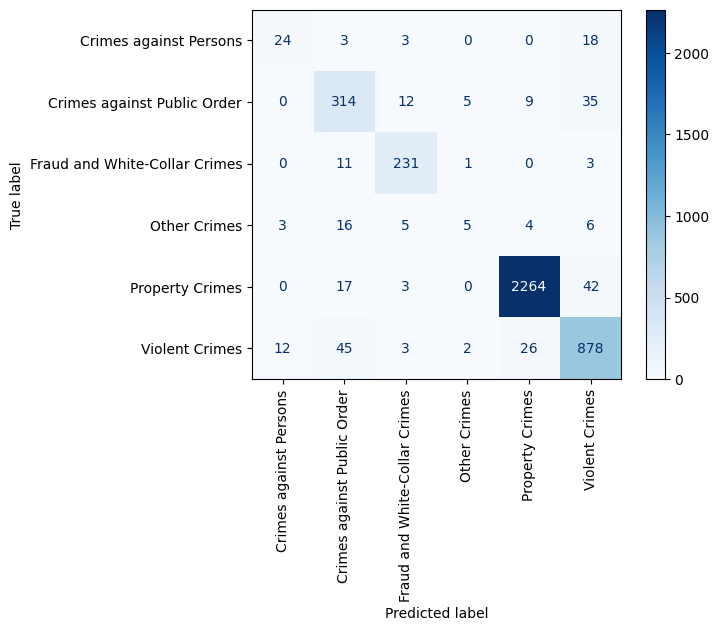

In [95]:
cm = confusion_matrix(valy, best_dtree_val_predictions_fs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = dtree_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [96]:
report = classification_report(valy, best_dtree_val_predictions_fs, target_names=dtree_best_model.classes_)
print(report)

                               precision    recall  f1-score   support

       Crimes against Persons       0.62      0.50      0.55        48
  Crimes against Public Order       0.77      0.84      0.80       375
Fraud and White-Collar Crimes       0.90      0.94      0.92       246
                 Other Crimes       0.38      0.13      0.19        39
              Property Crimes       0.98      0.97      0.98      2326
               Violent Crimes       0.89      0.91      0.90       966

                     accuracy                           0.93      4000
                    macro avg       0.76      0.71      0.72      4000
                 weighted avg       0.93      0.93      0.93      4000



Now, I will use Stratified K-Fold Cross Validation to check if my model, with selected 50 features, is performing well on different folds of the data.

In [97]:
skf_dtree_with_50_features = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

dtree_skf_scores = cross_val_score(estimator = dtree_best_model, 
                         X = trf_trainXCopy[dtree_selected_50_features], 
                         y = trainy, 
                         cv = skf_dtree_with_50_features, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", dtree_skf_scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(dtree_skf_scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(dtree_skf_scores))

Stratified K-Fold Scores:  [0.9328125 0.9321875 0.929375  0.9309375 0.935    ]
Stratified K-Fold Scores (Mean):  0.9320625
Stratified K-Fold Scores (Std Dev):  0.001881239617911588


<a id="dtree-final"></a>
#### Decision Tree Classifier Final Interpretations

- **Stratified K-Fold Scores:**  *[0.9328125 0.9321875 0.929375  0.9309375 0.935    ]*
- **Stratified K-Fold Scores (Mean):**  *0.9320625*
- **Stratified K-Fold Scores (Std Dev):**  *0.001881239617911588*
<br>
- The mean cross-validation score (with 50 features) of 0.932 (93.2%) is quite close to the overall training accuracy (with 50 features) of 0.929 (92.9%). This indicates that the model's performance is consistent across different folds.
- Low standard deviation of 0.002 suggests that the model's performance is stable and does not vary much across different folds.
- The model shows consistent performance across different evaluation metrics (training, validation, and cross-validation). This consistency indicates that it generalizes well to new data, which is a crucial aspect of model robustness.

<a id="rforest"></a>
# Random Forest Classifier (Model 3)

In [98]:
# Base Random Forest Classifier With Default Param Values
rforest = RandomForestClassifier(n_estimators = 100,
                                       n_jobs=-1,
                                       random_state=5)
rforest.fit(trf_trainXCopy, trainy)

RandomForestClassifier(n_jobs=-1, random_state=5)

In [99]:
# Predictions With Base RF Estimator
base_rf_val_predictions = rforest.predict(val_trf)

base_rf_train_acc = rforest.score(trf_trainXCopy, trainy)
base_rf_val_acc = accuracy_score(valy, base_rf_val_predictions)

print("Training Accuracy: ", base_rf_train_acc)
print("Validation Accuracy: ", base_rf_val_acc)

Training Accuracy:  1.0
Validation Accuracy:  0.94225


In [100]:
base_rf_with_skf = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

scores = cross_val_score(estimator = rforest, 
                         X = trf_trainXCopy, 
                         y = trainy, 
                         cv = base_rf_with_skf, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.9365625 0.945     0.94      0.935625  0.9440625]
Stratified K-Fold Scores (Mean):  0.94025
Stratified K-Fold Scores (Std Dev):  0.003798642849755677


<a id="base-rforest"></a>
#### Insights on Base Random Forest Classifier Along With Cross Validation

- **Stratified K-Fold Scores:**  *[0.9365625 0.945     0.94      0.935625  0.9440625]*
- **Stratified K-Fold Scores (Mean):**  *0.94025*
- **Stratified K-Fold Scores (Std Dev):**  *0.003798642849755677*
<br>
- The mean cross-validation score of 94% is less compared to previous perfect 100% of base model.
- The standard deviation is 0.0037, which is quite low. This indicates that the base random forest model is generalizing well on different folds of the dataset.

In [101]:
tree_depths = [estimator.tree_.max_depth for estimator in rforest.estimators_]

# Printing tree depths
print("Max. Tree Depth: ", max(tree_depths))
print("Min. Tree Depth: ", min(tree_depths))

Max. Tree Depth:  62
Min. Tree Depth:  38


In [102]:
# rf_param_grid = {
#     'max_depth': [42, 45],
#     'min_samples_leaf': [2, 3, 5],
#     'min_samples_split': [6, 8, 10],
#     'ccp_alpha': [0.0005, 0.0001]
# }


# rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100,
#                                                                max_features=None,
#                                                                criterion="gini",
#                                                                warm_start=True, 
#                                                                n_jobs=-1, 
#                                                                random_state=5), 
#                                  param_grid = rf_param_grid,
#                                  cv=3,
#                                  verbose=1,
#                                  scoring='accuracy', 
#                                  n_jobs=-1)

# rf_grid_search.fit(trf_trainXCopy, trainy)

In [103]:
# rforest_best_model = rf_grid_search.best_estimator_
# rforest_best_params = rf_grid_search.best_params_
# print("Best Parameters for Random Forest Classifier: ", rforest_best_params)
# print("Mean Cross-Validated Score of Best Estimator: ", rf_grid_search.best_score_)

In [104]:
rforest_best_params = {'ccp_alpha': 0.0001, 'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 6}
rforest_best_model = RandomForestClassifier(n_estimators=100,
                                            max_features=None,
                                            criterion="gini",
                                            warm_start=True, 
                                            n_jobs=-1, 
                                            random_state=5,
                                            **rforest_best_params)

rforest_best_model.fit(trf_trainXCopy, trainy)

RandomForestClassifier(ccp_alpha=0.0001, max_depth=42, max_features=None,
                       min_samples_leaf=2, min_samples_split=6, n_jobs=-1,
                       random_state=5, warm_start=True)

In [105]:
# Decision Tree Model accuracy with tuned parameters

best_rforest_val_predictions = rforest_best_model.predict(val_trf)
best_rforest_train_acc = rforest_best_model.score(trf_trainXCopy, trainy)
best_rforest_val_acc = accuracy_score(valy, best_rforest_val_predictions)

print("Training Accuracy: ", best_rforest_train_acc)
print("Validation Accuracy: ", best_rforest_val_acc)

Training Accuracy:  0.9740625
Validation Accuracy:  0.93775


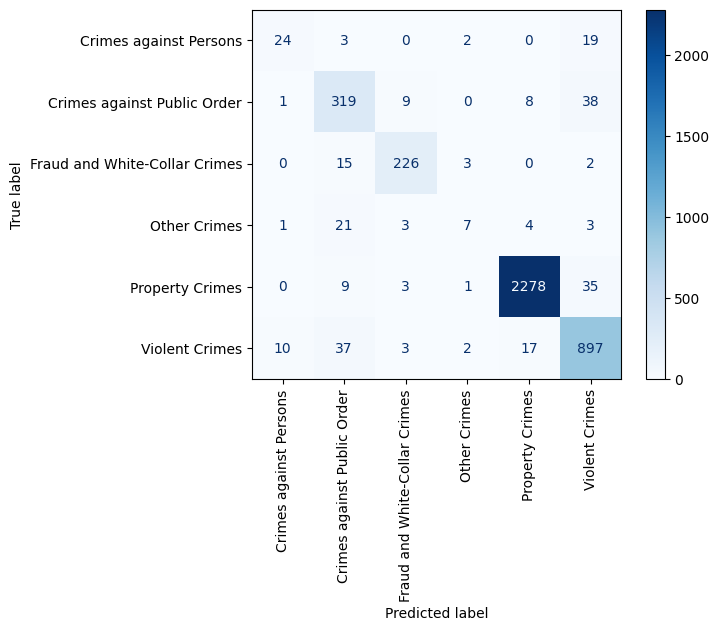

In [106]:
cm = confusion_matrix(valy, best_rforest_val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = rforest_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [107]:
report = classification_report(valy, best_rforest_val_predictions, target_names=rforest_best_model.classes_)
print(report)

                               precision    recall  f1-score   support

       Crimes against Persons       0.67      0.50      0.57        48
  Crimes against Public Order       0.79      0.85      0.82       375
Fraud and White-Collar Crimes       0.93      0.92      0.92       246
                 Other Crimes       0.47      0.18      0.26        39
              Property Crimes       0.99      0.98      0.98      2326
               Violent Crimes       0.90      0.93      0.92       966

                     accuracy                           0.94      4000
                    macro avg       0.79      0.73      0.75      4000
                 weighted avg       0.94      0.94      0.94      4000



<a id="rforest-tuning"></a>
#### Insights After Hyper Parameter Tuning On Random Forest Classifier

- **Best Parameters for Random Forest Classifier:**  *{'ccp_alpha': 0.0001, 'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 6}*
- **Mean Cross-Validated Score of Best Estimator:**  *0.9403749175080848*
<br>
- With tuned parameters, I am getting the training accuracy of 97.4%, which is lower that previous perfect 100%. This indicates that the model is no longer overfitting, and generalizing well on training data.
- The current validation accracy of 93.775% is slightly lower than the previous validation accuracy of 94.225%, indicating consistent generalization to unseen data.

In [108]:
# Searching for best features using best decision tree model.
# n_features_to_select = [150, 100, 50]
# for i in n_features_to_select:
#     rforest_with_rfe = RFE(rforest_best_model, n_features_to_select=i)
#     rforest_with_rfe.fit(trf_trainXCopy, trainy)
    
#     selected_features_with_rfe = trf_trainXCopy.columns[rforest_with_rfe.support_]
    
#     rforest_with_rfe.fit(trf_trainXCopy[selected_features_with_rfe], trainy)
#     rforest_rfe_val_predictions = rforest_with_rfe.predict(val_trf[selected_features_with_rfe])
    
#     rforest_rfe_train_acc = rforest_with_rfe.score(trf_trainXCopy[selected_features_with_rfe], trainy)
#     rforest_rfe_val_acc = accuracy_score(valy, rforest_rfe_val_predictions)
    
#     print(f"Scores With {i} Features:")
#     print("Training Accuracy: ", rforest_rfe_train_acc)
#     print("Validation Accuracy: ", rforest_rfe_val_acc)



<a id="insights-rfe-rforest"></a>
#### Insights On Random Forest Classifier After RFE Feature Selection
**Scores with All Features**
- Training Accuracy:  0.9745625
- Validation Accuracy:  0.93775

**Scores With 150 Features:**
- Training Accuracy:  0.9744375
- Validation Accuracy:  0.93775

**Scores With 100 Features:**
- Training Accuracy:  0.974
- Validation Accuracy:  0.93775

**Scores With 50 Features:**
 - Training Accuracy:  0.9699375
 - Validation Accuracy:  0.9335
 

#### Insights
- The training and validation accuracies are quite similar across different feature sets. This suggests that the model's performance is robust to the number of features selected.
- The model performs well even with 50, and 100 features. This suggests that these features are capturing the most important information needed for the model to make accurate predictions.

**RFE Best 100 Features**: <br>
['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_108.0', 'Premise_Code_122.0', 'Premise_Code_501.0', 'Premise_Code_502.0', 'Premise_Code_Others', 'Area_ID_1.0', 'Area_ID_2.0', 'Area_ID_6.0', 'Area_ID_9.0', 'Area_ID_10.0', 'Area_ID_12.0', 'Area_ID_13.0', 'Area_ID_15.0', 'Area_ID_16.0', 'Area_ID_17.0', 'Area_ID_18.0', 'Area_ID_20.0', 'Victim_Sex_F', 'Victim_Sex_M', 'Victim_Sex_X', 'Victim_Age_Group', 'victim_descent_B', 'victim_descent_H', 'victim_descent_O', 'victim_descent_W', 'Time_Occurred_Range', 'Date_Occurred_Weekday', 'Status_AA', 'Status_AO', 'Status_IC', 'Occurred_Reported_Diff', 'Part 1-2', 'Date_Occurred_Month', '0100', '0302', '0325', '0329', '0334', '0337', '0342', '0344', '0346', '0355', '0356', '0377', '0385', '0394', '0400', '0401', '0408', '0411', '0416', '0417', '0419', '0421', '0429', '0430', '0431', '0432', '0443', '0444', '0445', '0446', '0447', '0448', '0450', '0500', '0522', '0527', '0603', '0701', '0906', '0913', '0922', '0928', '0929', '0930', '1100', '1212', '1218', '1243', '1258', '1259', '1300', '1309', '1310', '1402', '1407', '1501', '1607', '1609', '1817', '1822', '1906', '2000', '2004', '2038', 'Others']


Finally, I'll go with 100 features for my Random forest Classifier.

In [109]:
rforest_best_100_features = ['Premise_Code_101.0', 'Premise_Code_102.0', 'Premise_Code_108.0', 'Premise_Code_122.0', 
                             'Premise_Code_501.0', 'Premise_Code_502.0', 'Premise_Code_Others', 'Area_ID_1.0', 
                             'Area_ID_2.0', 'Area_ID_6.0', 'Area_ID_9.0', 'Area_ID_10.0', 'Area_ID_12.0', 'Area_ID_13.0', 
                             'Area_ID_15.0', 'Area_ID_16.0', 'Area_ID_17.0', 'Area_ID_18.0', 'Area_ID_20.0', 'Victim_Sex_F', 
                             'Victim_Sex_M', 'Victim_Sex_X', 'Victim_Age_Group', 'victim_descent_B', 'victim_descent_H', 
                             'victim_descent_O', 'victim_descent_W', 'Time_Occurred_Range', 'Date_Occurred_Weekday', 
                             'Status_AA', 'Status_AO', 'Status_IC', 'Occurred_Reported_Diff', 'Part 1-2', 
                             'Date_Occurred_Month', '0100', '0302', '0325', '0329', '0334', '0337', '0342', '0344', 
                             '0346', '0355', '0356', '0377', '0385', '0394', '0400', '0401', '0408', '0411', '0416', 
                             '0417', '0419', '0421', '0429', '0430', '0431', '0432', '0443', '0444', '0445', '0446', 
                             '0447', '0448', '0450', '0500', '0522', '0527', '0603', '0701', '0906', '0913', '0922', 
                             '0928', '0929', '0930', '1100', '1212', '1218', '1243', '1258', '1259', '1300', '1309', 
                             '1310', '1402', '1407', '1501', '1607', '1609', '1817', '1822', '1906', '2000', '2004', 
                             '2038', 'Others']

In [110]:
rforest_best_model = RandomForestClassifier(n_estimators=100,
                                            max_features=None,
                                            criterion="gini",
                                            warm_start=True, 
                                            n_jobs=-1, 
                                            random_state=5,
                                            **rforest_best_params)
rforest_best_model.fit(trf_trainXCopy[rforest_best_100_features], trainy)

# Logit model accuracy after feature selection

best_rforest_val_predictions_fs = rforest_best_model.predict(val_trf[rforest_best_100_features])
best_rforest_train_acc_fs = rforest_best_model.score(trf_trainXCopy[rforest_best_100_features], trainy)
best_rforest_val_acc_fs = accuracy_score(valy, best_rforest_val_predictions_fs)

print("Training Accuracy: ", best_rforest_train_acc_fs)
print("Validation Accuracy: ", best_rforest_val_acc_fs)

Training Accuracy:  0.9739375
Validation Accuracy:  0.93775


In [111]:
skf_rforest_with_100_features = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

rforest_skf_scores = cross_val_score(estimator = rforest_best_model, 
                         X = trf_trainXCopy[rforest_best_100_features], 
                         y = trainy, 
                         cv = skf_rforest_with_100_features, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", rforest_skf_scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(rforest_skf_scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(rforest_skf_scores))

Stratified K-Fold Scores:  [0.945     0.9446875 0.9425    0.935625  0.9465625]
Stratified K-Fold Scores (Mean):  0.9428749999999999
Stratified K-Fold Scores (Std Dev):  0.0038497158986085986


<a id="rforest-final"></a>
#### Random Forest Classifier Final Interpretations

- **Stratified K-Fold Scores:**  *[0.945     0.9446875 0.9425    0.935625  0.9465625]*
- **Stratified K-Fold Scores (Mean):**  *0.9428749999999999*
- **Stratified K-Fold Scores (Std Dev):**  *0.0038497158986085986*
<br>
- The mean cross-validation score (with 100 features) of 0.943 (94.3%) is quite close to the overall training accuracy (with 100 features) of 0.974 (97.4%). This indicates that the model's performance is consistent across different folds.
- Low standard deviation of 0.003 suggests that the model's performance is stable and does not vary much across different folds.
- The model shows consistent performance across different evaluation metrics (training, validation, and cross-validation). This consistency indicates that it generalizes well to new data, which is a crucial aspect of model robustness.

<a id="svc"></a>
# Support Vector Classifier (Model 4)

In [112]:
# Using MinMaxScaler, as I found that SVC model is performing much better with scaling, especially MinMaxScaler 
mx = MinMaxScaler()
trf_trXCopy = mx.fit_transform(trf_trainXCopy)
val_trfstd = mx.transform(val_trf)

In [113]:
# Base Support Vector Classifier

svc = SVC(kernel="rbf", tol=1e-3, random_state=5)
svc.fit(trf_trXCopy, trainy)
svc_pred = svc.predict(val_trfstd)

print("training acc: ", svc.score(trf_trXCopy, trainy))
print("validation acc: ", accuracy_score(valy, svc_pred))

training acc:  0.96725
validation acc:  0.942


In [114]:
base_svc_with_skf = StratifiedKFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=5)

scores = cross_val_score(estimator = svc, 
                         X = trf_trXCopy, 
                         y = trainy, 
                         cv = base_svc_with_skf, 
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.9421875 0.946875  0.949375  0.9378125 0.9446875]
Stratified K-Fold Scores (Mean):  0.9441875
Stratified K-Fold Scores (Std Dev):  0.003975510973447297


<a id="base-svc"></a>
#### Insights on Base SVC Along With Cross Validation
- **Stratified K-Fold Scores:**  *[0.9421875 0.946875  0.949375  0.9378125 0.9446875]*
- **Stratified K-Fold Scores (Mean):**  *0.9441875*
- **Stratified K-Fold Scores (Std Dev):**  *0.003975510973447297*
<br>
- The mean cross-validation score 94.4% is slightly less than overall training accuracy of 96.7%. This shows that model is performing good and is consistent on different subsets of the data.
- Also, the standard deviation is less i.e 0.004.

In [115]:
# svc_param_grid = {
#     'kernel': ['rbf', 'poly'],
#     'degree': [2, 3, 4],
#     'C': [0.9, 1, 10],
#     'tol': [1e-5, 1e-4, 1e-3],
#     'decision_function_shape': ['ovo', 'ovr'],
# }

# svc_gs = GridSearchCV(estimator=SVC(random_state=5),
#                       param_grid=svc_param_grid,
#                       cv=2,
#                       verbose=1,
#                       scoring='accuracy',
#                       n_jobs=-1)

# svc_gs.fit(trf_trXCopy, trainy)

In [116]:
# svc_best_model = svc_gs.best_estimator_
# svc_best_params = svc_gs.best_params_
# print("Best Parameters for SVC: ", svc_best_params)
# print("Mean Cross-Validated Score of Best Estimator: ", svc_gs.best_score_)

In [117]:
svc_best_params = {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'kernel': 'poly', 'tol': 1e-05}
svc_best_model = SVC(random_state=5,
                     **svc_best_params)

svc_best_model.fit(trf_trXCopy, trainy)

SVC(C=1, decision_function_shape='ovo', degree=2, kernel='poly', random_state=5,
    tol=1e-05)

In [118]:
# SVC Model accuracy with tuned parameters

best_svc_val_predictions = svc_best_model.predict(val_trfstd)
best_svc_train_acc = svc_best_model.score(trf_trXCopy, trainy)
best_svc_val_acc = accuracy_score(valy, best_svc_val_predictions)

print("Training Accuracy: ", best_svc_train_acc)
print("Validation Accuracy: ", best_svc_val_acc)

Training Accuracy:  0.9695
Validation Accuracy:  0.94125


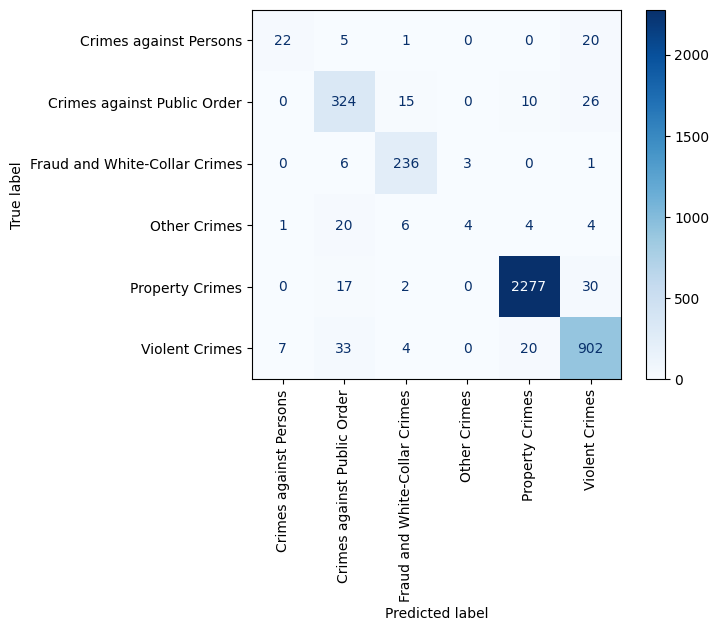

In [119]:
cm = confusion_matrix(valy, best_svc_val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = svc_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [120]:
report = classification_report(valy, best_svc_val_predictions, target_names=svc_best_model.classes_)
print(report)

                               precision    recall  f1-score   support

       Crimes against Persons       0.73      0.46      0.56        48
  Crimes against Public Order       0.80      0.86      0.83       375
Fraud and White-Collar Crimes       0.89      0.96      0.93       246
                 Other Crimes       0.57      0.10      0.17        39
              Property Crimes       0.99      0.98      0.98      2326
               Violent Crimes       0.92      0.93      0.93       966

                     accuracy                           0.94      4000
                    macro avg       0.82      0.72      0.73      4000
                 weighted avg       0.94      0.94      0.94      4000



<a id="svc-tuning"></a>
#### Insights After Hyper-Parameter Tuning Of SVC
- **Best Parameters for SVC:**  *{'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'kernel': 'poly', 'tol': 1e-05}*
- **Mean Cross-Validated Score of Best Estimator:**  *0.9405625*
- After hyperparameter tuning, the training accuracy slightly increased from 96.7% to 96.95%. Though, the validation accuracy is dropped slightly. 

In [121]:
best_svc_with_skf = StratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=5)

scores = cross_val_score(estimator = svc_best_model,
                         X = trf_trXCopy,
                         y = trainy,
                         cv = best_svc_with_skf,
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.9415625 0.94375   0.9484375 0.93875   0.945625 ]
Stratified K-Fold Scores (Mean):  0.9436249999999999
Stratified K-Fold Scores (Std Dev):  0.0033225084650005334


<a id="svc-final"></a>
#### SVC Final Interpretations

- **Stratified K-Fold Scores:**  *[0.9415625 0.94375   0.9484375 0.93875   0.945625 ]*
- **Stratified K-Fold Scores (Mean):**  *0.9436249999999999*
- **Stratified K-Fold Scores (Std Dev):**  *0.0033225084650005334*
<br>
- The mean scores is more or less similar to the training accuracy of 97% with tuned model. 

<a id='lgbm'></a>
# LGBMClassifier (Model 5)

In [122]:
# fitting base LGBMClassifier
lgbm = LGBMClassifier(random_state=5, verbose=-1)
lgbm.fit(trf_trainXCopy, trainy)

LGBMClassifier(random_state=5, verbose=-1)

In [123]:
lgbm_val_predictions = lgbm.predict(val_trf)

print("training acc: ", lgbm.score(trf_trainXCopy, trainy))
print("validation acc: ", accuracy_score(valy, lgbm_val_predictions))

training acc:  0.997875
validation acc:  0.94775


In [124]:
# lgbm_param_grid = {
#     'num_leaves': [40, 45, 50],
#     'max_depth': [-1, 5],
#     'learning_rate': [0.9, 0.1, 0.01],
#     'n_estimators': [100, 200, 300],
#     'min_child_samples': [20, 25, 35]
# }

# lgbm_gs = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# lgbm_gs.fit(trf_trainXCopy, trainy)

In [125]:
# lgbm_best_model = lgbm_gs.best_estimator_
# lgbm_best_params = lgbm_gs.best_params_
# print("Best Parameters for SVC: ", lgbm_best_params)
# print("Mean Cross-Validated Score of Best Estimator: ", lgbm_gs.best_score_)

In [126]:
lgbm_best_params = {'learning_rate': 0.1, 
                    'max_depth': -1, 
                    'min_child_samples': 25, 
                    'n_estimators': 200, 
                    'num_leaves': 45}
lgbm_best_model = LGBMClassifier(random_state=5, verbose=-1,
                     **lgbm_best_params)

lgbm_best_model.fit(trf_trainXCopy, trainy)

LGBMClassifier(min_child_samples=25, n_estimators=200, num_leaves=45,
               random_state=5, verbose=-1)

In [127]:
# LGBMClassifier Model accuracy with tuned parameters

best_lgbm_val_predictions = lgbm_best_model.predict(val_trf)
best_lgbm_train_acc = lgbm_best_model.score(trf_trainXCopy, trainy)
best_lgbm_val_acc = accuracy_score(valy, best_lgbm_val_predictions)

print("Training Accuracy: ", best_lgbm_train_acc)
print("Validation Accuracy: ", best_lgbm_val_acc)

Training Accuracy:  1.0
Validation Accuracy:  0.9485


<a id="lgbm-tuning"></a>
#### Insights After Hyper-parameter Tuning of LGBMClassifier

- **LGBM Best Params:** *{'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 25, 'n_estimators': 200, 'num_leaves': 45}*
- **Training Accuracy (After Tuning):**  *1.0*
- **Validation Accuracy (After Tuning):**  *0.9485*

In [128]:
# # Searching for best features using best lgbm model.
# n_features_to_select = [150, 100, 50]
# for i in n_features_to_select:
#     lgbm_with_rfe = RFE(lgbm_best_model, n_features_to_select=i)
#     lgbm_with_rfe.fit(trf_trainXCopy, trainy)
    
#     selected_features_with_rfe = trf_trainXCopy.columns[lgbm_with_rfe.support_]
    
#     lgbm_with_rfe.fit(trf_trainXCopy[selected_features_with_rfe], trainy)
#     lgbm_rfe_val_predictions = lgbm_with_rfe.predict(val_trf[selected_features_with_rfe])
    
#     lgbm_rfe_train_acc = lgbm_with_rfe.score(trf_trainXCopy[selected_features_with_rfe], trainy)
#     lgbm_rfe_val_acc = accuracy_score(valy, lgbm_rfe_val_predictions)
    
#     print(f"Scores With {i} Features:")
#     print("Training Accuracy: ", lgbm_rfe_train_acc)
#     print("Validation Accuracy: ", lgbm_rfe_val_acc)

<a id="lgbm-rfe"></a>
#### Insights After RFE Feature Selection LightGBM Model

**Scores With 150 Features:**
- Training Accuracy:  1.0
- Validation Accuracy:  0.9475

**Scores With 100 Features:**
- Training Accuracy:  1.0
- Validation Accuracy:  0.939

**Scores With 50 Features:**
- Training Accuracy:  0.9994375
- Validation Accuracy:  0.9115
<br>

The LGBM model scores is best with all features taken into account.

In [129]:
best_lgbm_with_skf = StratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=5)

scores = cross_val_score(estimator = lgbm_best_model,
                         X = trf_trainXCopy,
                         y = trainy,
                         cv = best_lgbm_with_skf,
                         scoring = "accuracy")

print("Stratified K-Fold Scores: ", scores)
print("Stratified K-Fold Scores (Mean): ", np.mean(scores))
print("Stratified K-Fold Scores (Std Dev): ", np.std(scores))

Stratified K-Fold Scores:  [0.949375  0.9534375 0.955625  0.94375   0.955    ]
Stratified K-Fold Scores (Mean):  0.9514374999999999
Stratified K-Fold Scores (Std Dev):  0.004417649261768071


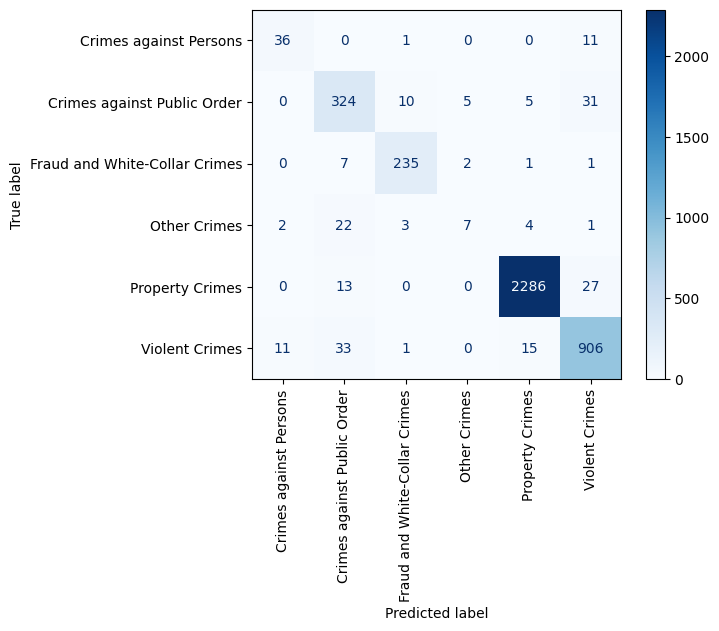

In [130]:
cm = confusion_matrix(valy, best_lgbm_val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = lgbm_best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [131]:
report = classification_report(valy, best_lgbm_val_predictions, target_names=lgbm_best_model.classes_)
print(report)

                               precision    recall  f1-score   support

       Crimes against Persons       0.73      0.75      0.74        48
  Crimes against Public Order       0.81      0.86      0.84       375
Fraud and White-Collar Crimes       0.94      0.96      0.95       246
                 Other Crimes       0.50      0.18      0.26        39
              Property Crimes       0.99      0.98      0.99      2326
               Violent Crimes       0.93      0.94      0.93       966

                     accuracy                           0.95      4000
                    macro avg       0.82      0.78      0.78      4000
                 weighted avg       0.95      0.95      0.95      4000



- LGBMClassifier is performing best compared to other models in predicting **Crimes against Persons** class, as this class is highly under-represented in our dataset.

<a id="final-model-comp"></a>
# Final Model Comparison And Submission

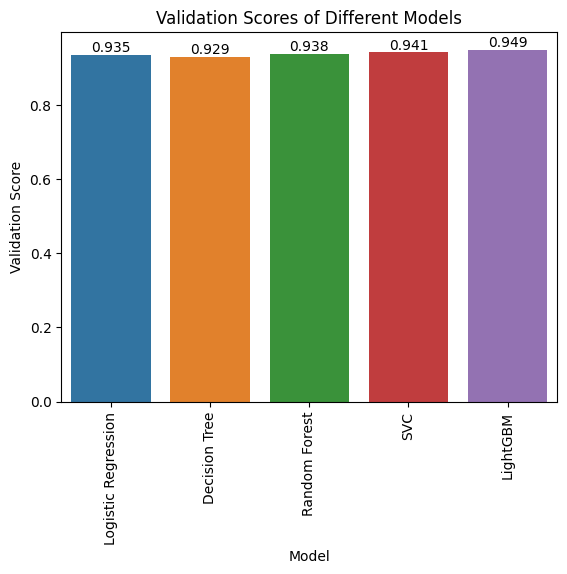

In [132]:
model_scores = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "SVC", "LightGBM"],
    "Validation Score": [best_logit_val_acc_fs, best_dtree_val_acc_fs, best_rforest_val_acc_fs, best_svc_val_acc, best_lgbm_val_acc]
}

model_scores_df = pd.DataFrame(data=model_scores, columns=model_scores.keys())

ax = sns.barplot(data=model_scores_df, x="Model", y="Validation Score")
for i, v in enumerate(model_scores_df["Validation Score"]):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
plt.title("Validation Scores of Different Models")
plt.xticks(rotation=90)

plt.show()

- The LightGBM Classifier is performing the best, and Decision Tree is performing comparatively least.


In [133]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           810 non-null    object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         4316 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             4357 non-null   object 
 14  Victim_Descent         4357 non-null   object 
 15  Prem

In [134]:
testData_preprocessed = operations_on_test_data(testData)
testData_transformed = transformer.transform(testData_preprocessed)
testData_trf = pd.DataFrame(testData_transformed, columns=transformer.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0372', '0393', '0403', '0518', '0540', '0557', '0854', '0946', '1011', '1231', '1233', '1255', '1314', '1410', '2011', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


In [135]:
testData_predictions = lgbm_best_model.predict(testData_trf)

In [136]:
# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(trainX, trainy)
# y_pred = dummy_clf.predict(testX)
# accuracy = accuracy_score(testy, y_pred)
# print(accuracy)

In [137]:
# testData.fillna(0, inplace=True)
# prediction = dummy_clf.predict(testData)

In [138]:
sample = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv")

In [139]:
sample.head()

,ID,Crime_Category,Unnamed: 2
0,1,Crimes against Persons,NaN
1,2,Crimes against Public Order,NaN
2,3,Other Crimes,NaN
3,4,Crimes against Public Order,NaN
4,5,Other Crimes,NaN


In [140]:
submission = pd.DataFrame(columns = ["ID", "Crime_Category"])
submission["ID"] = [i for i in range(1, len(testData_predictions)+1)]
submission["Crime_Category"] = testData_predictions
submission.to_csv("submission.csv", index=False)

In [141]:
submission.head()

,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Fraud and White-Collar Crimes
3,4,Property Crimes
4,5,Crimes against Public Order
